In [ ]:
import math
import os
import random

import flip_evaluator as flip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


PARAMS = {
    "seed": 42,
    "csv_path": "../output/frame_parameters.csv",
    "image_dir": "../output",
    "batch_size": 32,
    "train_split": 0.8,
    "num_epochs": 500,
    "learning_rate": 0.001,
    "scheduler_step_size": 100,
    "scheduler_gamma": 0.5,
    "input_dim": 24,
    "output_size": (128, 128),
    "visualization_freq": 10,
    "vis_dir": "visualizations",
    "checkpoint_path": "checkpoints",
}

os.makedirs(PARAMS["vis_dir"], exist_ok=True)

set_seed(PARAMS["seed"])


In [ ]:
class FrameDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.camera_pos = [5.0, 5.0, 15.0]
        self.max_r = math.sqrt(25**2 + 25**2 + 35**2)
        self.r_range = [0, self.max_r]
        self.theta_range = [0, math.pi]
        self.phi_range = [-math.pi, math.pi]
        self.shininess_range = [3, 20]
        self.diffuse_range = [0, 1]
        self.image_files = [f"image_{str(i).zfill(4)}.png" for i in self.data["frame"]]
        self.params_tensor = self.preprocess_data()

    def __len__(self):
        return len(self.data)

    def normalize(self, value, range_min, range_max):
        return 2 * ((value - range_min) / (range_max - range_min)) - 1

    def get_orthonormal_basis(self, z_prime):
        ref = [0, 0, 1] if abs(z_prime[2]) <= 0.99 else [0, 1, 0]
        x_prime = [
            z_prime[1] * ref[2] - z_prime[2] * ref[1],
            z_prime[2] * ref[0] - z_prime[0] * ref[2],
            z_prime[0] * ref[1] - z_prime[1] * ref[0],
        ]
        x_norm = math.sqrt(sum(x * x for x in x_prime))
        x_prime = [x / x_norm for x in x_prime]
        y_prime = [
            z_prime[1] * x_prime[2] - z_prime[2] * x_prime[1],
            z_prime[2] * x_prime[0] - z_prime[0] * x_prime[2],
            z_prime[0] * x_prime[1] - z_prime[1] * x_prime[0],
        ]
        y_norm = math.sqrt(sum(y * y for y in y_prime))
        y_prime = [y / y_norm for y in y_prime]
        return x_prime, y_prime, z_prime

    def cartesian_to_spherical_lookat(self, x, y, z, lookat_vec):
        x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)
        x_new = x * x_prime[0] + y * x_prime[1] + z * x_prime[2]
        y_new = x * y_prime[0] + y * y_prime[1] + z * y_prime[2]
        z_new = x * z_prime[0] + y * z_prime[1] + z * z_prime[2]
        r = math.sqrt(x_new**2 + y_new**2 + z_new**2)
        theta = math.acos(z_new / r) if r > 0 else 0
        phi = math.atan2(y_new, x_new)
        return r, theta, phi

    def preprocess_data(self):
        params_list = []
        for idx in range(len(self.data)):
            row = self.data.iloc[idx]
            lookat_x_rel = row["lookat_target_x"] - self.camera_pos[0]
            lookat_y_rel = row["lookat_target_y"] - self.camera_pos[1]
            lookat_z_rel = row["lookat_target_z"] - self.camera_pos[2]
            lookat_norm = math.sqrt(lookat_x_rel**2 + lookat_y_rel**2 + lookat_z_rel**2)
            lookat_vec = (
                [lookat_x_rel / lookat_norm, lookat_y_rel / lookat_norm, lookat_z_rel / lookat_norm]
                if lookat_norm > 0 else [0, 0, 0]
            )
            model_x_rel = row["model_translation_x"] - self.camera_pos[0]
            model_y_rel = row["model_translation_y"] - self.camera_pos[1]
            model_z_rel = row["model_translation_z"] - self.camera_pos[2]
            model_r, model_theta, model_phi = self.cartesian_to_spherical_lookat(
                model_x_rel, model_y_rel, model_z_rel, lookat_vec
            )
            light_x_rel = row["light_position_x"] - self.camera_pos[0]
            light_y_rel = row["light_position_y"] - self.camera_pos[1]
            light_z_rel = row["light_position_z"] - self.camera_pos[2]
            light_r, light_theta, light_phi = self.cartesian_to_spherical_lookat(
                light_x_rel, light_y_rel, light_z_rel, lookat_vec
            )
            light_to_model_vec = [
                light_x_rel - model_x_rel,
                light_y_rel - model_y_rel,
                light_z_rel - model_z_rel,
            ]
            ltm_norm = math.sqrt(sum(x**2 for x in light_to_model_vec))
            light_to_model_unit = [
                x / ltm_norm if ltm_norm > 0 else 0 for x in light_to_model_vec
            ]
            cos_view_light = sum(l * v for l, v in zip(light_to_model_unit, lookat_vec))
            ltm_normalized = self.normalize(ltm_norm, 0, self.max_r)
            x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)

            def rotate_to_view(x, y, z):
                return [
                    x * x_prime[0] + y * x_prime[1] + z * x_prime[2],
                    x * y_prime[0] + y * y_prime[1] + z * y_prime[2],
                    x * z_prime[0] + y * z_prime[1] + z * z_prime[2],
                ]

            model_view_xyz = rotate_to_view(model_x_rel, model_y_rel, model_z_rel)
            light_view_xyz = rotate_to_view(light_x_rel, light_y_rel, light_z_rel)
            params = [
                self.normalize(model_r, *self.r_range),
                self.normalize(model_theta, *self.theta_range),
                self.normalize(model_phi, *self.phi_range),
                self.normalize(light_r, *self.r_range),
                self.normalize(light_theta, *self.theta_range),
                self.normalize(light_phi, *self.phi_range),
                *lookat_vec,
                self.normalize(row["material_diffuse_r"], *self.diffuse_range),
                self.normalize(row["material_diffuse_g"], *self.diffuse_range),
                self.normalize(row["material_diffuse_b"], *self.diffuse_range),
                self.normalize(row["material_shininess"], *self.shininess_range),
                ltm_normalized,
                cos_view_light,
                *light_to_model_unit,
                *model_view_xyz,
                *light_view_xyz,
            ]
            params_list.append(params)
        return torch.tensor(params_list, dtype=torch.float32)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        params_tensor = self.params_tensor[idx]
        return image, params_tensor

def get_data_loaders(csv_path, image_dir, batch_size, train_split):
    transform = transforms.Compose([
        transforms.Resize(PARAMS['output_size']),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    dataset = FrameDataset(csv_path, image_dir, transform=transform)
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader


In [ ]:
class ImageGenerator(nn.Module):
    def __init__(self, input_dim, output_size):
        super(ImageGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 4 * 4),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        batch_size = x.size(0)
        features = self.fc(x)
        features = features.view(batch_size, 128, 4, 4)
        return self.decoder(features)


def denormalize(img):
    return (img * 0.5) + 0.5


def compute_flip_metrics(outputs, images):
    gen_images = denormalize(outputs).cpu().detach().permute(0, 2, 3, 1).numpy()
    gt_images = denormalize(images).cpu().detach().permute(0, 2, 3, 1).numpy()
    batch_flip = 0.0
    for i in range(gen_images.shape[0]):
        _, mean_flip_error, _ = flip.evaluate(gt_images[i], gen_images[i], "LDR")
        batch_flip += mean_flip_error
    return batch_flip / gen_images.shape[0]


def visualize_samples(model, val_loader, epoch, vis_dir):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        sample_images, sample_params = next(iter(val_loader))
        sample_images, sample_params = (
            sample_images.to(device),
            sample_params.to(device),
        )
        generated_images = model(sample_params)
        generated_images = denormalize(generated_images).cpu()
        sample_images = denormalize(sample_images).cpu()

        plt.figure(figsize=(12, 6))
        for i in range(min(4, sample_images.size(0))):
            plt.subplot(2, 4, i + 1)
            plt.imshow(sample_images[i].permute(1, 2, 0).numpy())
            plt.title(f"Ground Truth {i + 1}")
            plt.axis("off")
            plt.subplot(2, 4, i + 5)
            plt.imshow(generated_images[i].permute(1, 2, 0).numpy())
            plt.title(f"Generated {i + 1}")
            plt.axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"epoch_{epoch}_samples.png"))
        plt.show()
        plt.close()


def plot_metrics(val_flip, vis_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(val_flip, label="Val FLIP", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("FLIP Score")
    plt.title("Validation FLIP Metric")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(vis_dir, "flip_metric.png"))
    plt.close()


In [ ]:
def train_model(model, train_loader, val_loader, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])

    train_losses, val_losses = [], []
    val_flips = []
    best_flip = float("inf")

    for epoch in range(params['num_epochs']):
        model.train()
        train_loss, train_samples = 0.0, 0
        for images, params_batch in train_loader:
            images, params_batch = images.to(device), params_batch.to(device)
            optimizer.zero_grad()
            outputs = model(params_batch)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_samples += images.size(0)

        model.eval()
        val_loss, val_flip, val_samples = 0.0, 0.0, 0
        with torch.no_grad():
            for images, params_batch in val_loader:
                images, params_batch = images.to(device), params_batch.to(device)
                outputs = model(params_batch)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)
                val_flip += compute_flip_metrics(outputs, images) * images.size(0)
                val_samples += images.size(0)

        train_loss_avg = train_loss / len(train_loader.dataset)
        val_loss_avg = val_loss / len(val_loader.dataset)
        val_flip_avg = val_flip / val_samples
        current_lr = scheduler.get_last_lr()[0]

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        val_flips.append(val_flip_avg)

        print(
            f"Epoch [{epoch + 1}/{params['num_epochs']}], "
            f"Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, "
            f"Val FLIP: {val_flip_avg:.4f}, LR: {current_lr:.6f}"
        )

        if val_flip_avg < best_flip:
            best_flip = val_flip_avg
            torch.save(model.state_dict(), os.path.join(params['checkpoint_path'], "best_model.pth"))
            print(f"Saved best model at epoch {epoch + 1} with FLIP {best_flip:.4f}")

        if (epoch + 1) % params['visualization_freq'] == 0:
            visualize_samples(model, val_loader, epoch + 1, params['vis_dir'])

        scheduler.step()

    plot_metrics(val_flips, params['vis_dir'])
    return train_losses, val_losses, [], val_flips


Epoch [1/500], Train Loss: 0.4496, Val Loss: 0.1015, Val FLIP: 0.4656, LR: 0.001000
Saved best model at epoch 1 with FLIP 0.4656
Epoch [2/500], Train Loss: 0.0551, Val Loss: 0.0306, Val FLIP: 0.2394, LR: 0.001000
Saved best model at epoch 2 with FLIP 0.2394
Epoch [3/500], Train Loss: 0.0231, Val Loss: 0.0174, Val FLIP: 0.1656, LR: 0.001000
Saved best model at epoch 3 with FLIP 0.1656
Epoch [4/500], Train Loss: 0.0156, Val Loss: 0.0135, Val FLIP: 0.1379, LR: 0.001000
Saved best model at epoch 4 with FLIP 0.1379
Epoch [5/500], Train Loss: 0.0124, Val Loss: 0.0112, Val FLIP: 0.1182, LR: 0.001000
Saved best model at epoch 5 with FLIP 0.1182
Epoch [6/500], Train Loss: 0.0108, Val Loss: 0.0100, Val FLIP: 0.1044, LR: 0.001000
Saved best model at epoch 6 with FLIP 0.1044
Epoch [7/500], Train Loss: 0.0098, Val Loss: 0.0095, Val FLIP: 0.0980, LR: 0.001000
Saved best model at epoch 7 with FLIP 0.0980
Epoch [8/500], Train Loss: 0.0093, Val Loss: 0.0088, Val FLIP: 0.0862, LR: 0.001000
Saved best mo

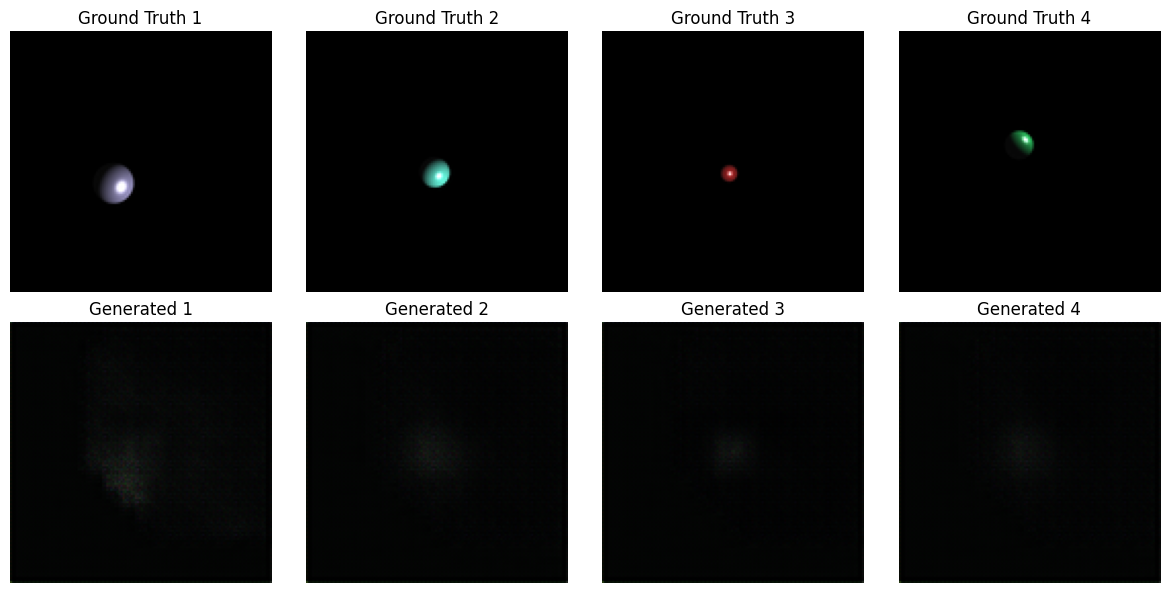

Epoch [11/500], Train Loss: 0.0085, Val Loss: 0.0081, Val FLIP: 0.0738, LR: 0.001000
Saved best model at epoch 11 with FLIP 0.0738
Epoch [12/500], Train Loss: 0.0082, Val Loss: 0.0080, Val FLIP: 0.0713, LR: 0.001000
Saved best model at epoch 12 with FLIP 0.0713
Epoch [13/500], Train Loss: 0.0081, Val Loss: 0.0079, Val FLIP: 0.0699, LR: 0.001000
Saved best model at epoch 13 with FLIP 0.0699
Epoch [14/500], Train Loss: 0.0080, Val Loss: 0.0079, Val FLIP: 0.0650, LR: 0.001000
Saved best model at epoch 14 with FLIP 0.0650
Epoch [15/500], Train Loss: 0.0079, Val Loss: 0.0078, Val FLIP: 0.0614, LR: 0.001000
Saved best model at epoch 15 with FLIP 0.0614
Epoch [16/500], Train Loss: 0.0078, Val Loss: 0.0078, Val FLIP: 0.0579, LR: 0.001000
Saved best model at epoch 16 with FLIP 0.0579
Epoch [17/500], Train Loss: 0.0078, Val Loss: 0.0077, Val FLIP: 0.0612, LR: 0.001000
Epoch [18/500], Train Loss: 0.0076, Val Loss: 0.0078, Val FLIP: 0.0569, LR: 0.001000
Saved best model at epoch 18 with FLIP 0.056

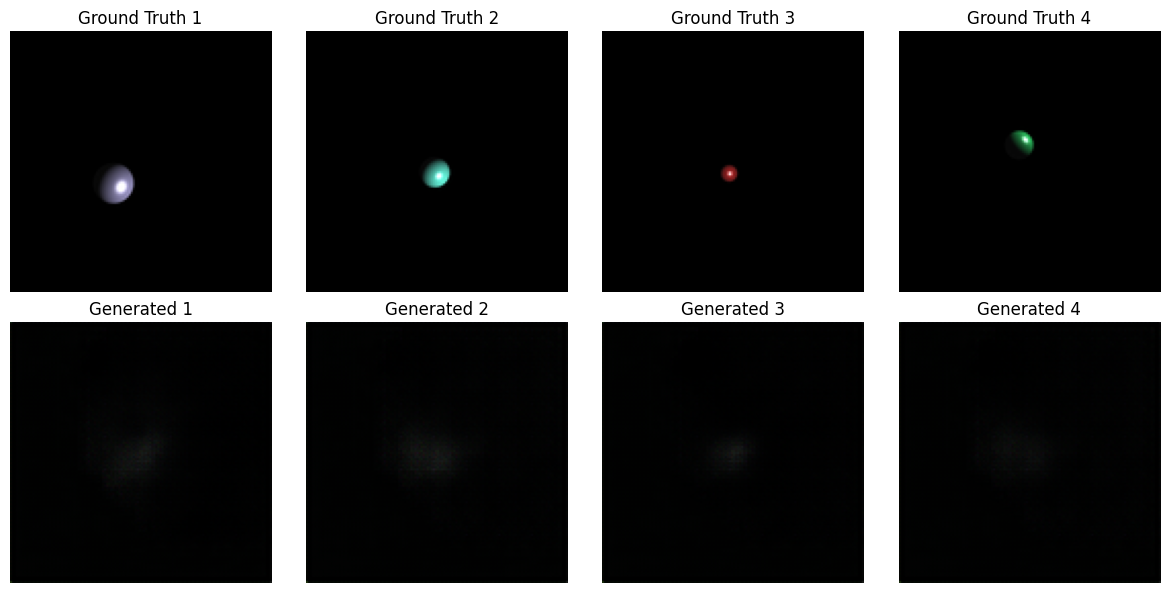

Epoch [21/500], Train Loss: 0.0074, Val Loss: 0.0077, Val FLIP: 0.0509, LR: 0.001000
Saved best model at epoch 21 with FLIP 0.0509
Epoch [22/500], Train Loss: 0.0075, Val Loss: 0.0080, Val FLIP: 0.0552, LR: 0.001000
Epoch [23/500], Train Loss: 0.0073, Val Loss: 0.0080, Val FLIP: 0.0519, LR: 0.001000
Epoch [24/500], Train Loss: 0.0072, Val Loss: 0.0075, Val FLIP: 0.0494, LR: 0.001000
Saved best model at epoch 24 with FLIP 0.0494
Epoch [25/500], Train Loss: 0.0070, Val Loss: 0.0076, Val FLIP: 0.0512, LR: 0.001000
Epoch [26/500], Train Loss: 0.0069, Val Loss: 0.0082, Val FLIP: 0.0516, LR: 0.001000
Epoch [27/500], Train Loss: 0.0070, Val Loss: 0.0076, Val FLIP: 0.0466, LR: 0.001000
Saved best model at epoch 27 with FLIP 0.0466
Epoch [28/500], Train Loss: 0.0066, Val Loss: 0.0079, Val FLIP: 0.0469, LR: 0.001000
Epoch [29/500], Train Loss: 0.0065, Val Loss: 0.0074, Val FLIP: 0.0451, LR: 0.001000
Saved best model at epoch 29 with FLIP 0.0451
Epoch [30/500], Train Loss: 0.0064, Val Loss: 0.007

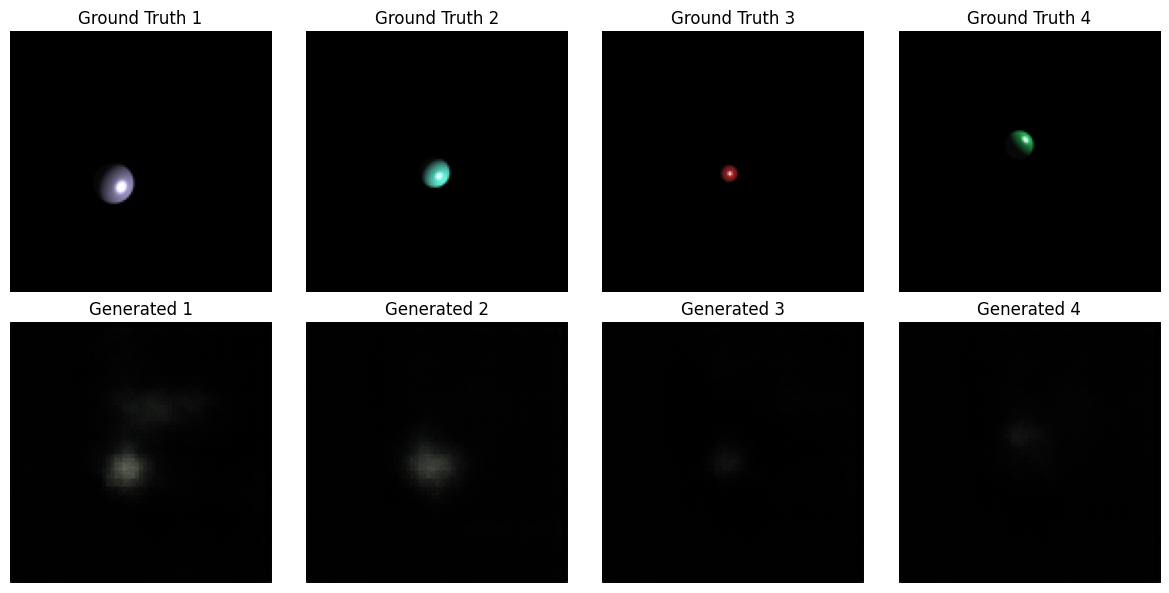

Epoch [31/500], Train Loss: 0.0062, Val Loss: 0.0077, Val FLIP: 0.0462, LR: 0.001000
Epoch [32/500], Train Loss: 0.0060, Val Loss: 0.0072, Val FLIP: 0.0436, LR: 0.001000
Saved best model at epoch 32 with FLIP 0.0436
Epoch [33/500], Train Loss: 0.0058, Val Loss: 0.0071, Val FLIP: 0.0432, LR: 0.001000
Saved best model at epoch 33 with FLIP 0.0432
Epoch [34/500], Train Loss: 0.0059, Val Loss: 0.0072, Val FLIP: 0.0434, LR: 0.001000
Epoch [35/500], Train Loss: 0.0056, Val Loss: 0.0070, Val FLIP: 0.0431, LR: 0.001000
Saved best model at epoch 35 with FLIP 0.0431
Epoch [36/500], Train Loss: 0.0054, Val Loss: 0.0069, Val FLIP: 0.0396, LR: 0.001000
Saved best model at epoch 36 with FLIP 0.0396
Epoch [37/500], Train Loss: 0.0052, Val Loss: 0.0068, Val FLIP: 0.0395, LR: 0.001000
Saved best model at epoch 37 with FLIP 0.0395
Epoch [38/500], Train Loss: 0.0050, Val Loss: 0.0068, Val FLIP: 0.0380, LR: 0.001000
Saved best model at epoch 38 with FLIP 0.0380
Epoch [39/500], Train Loss: 0.0049, Val Loss

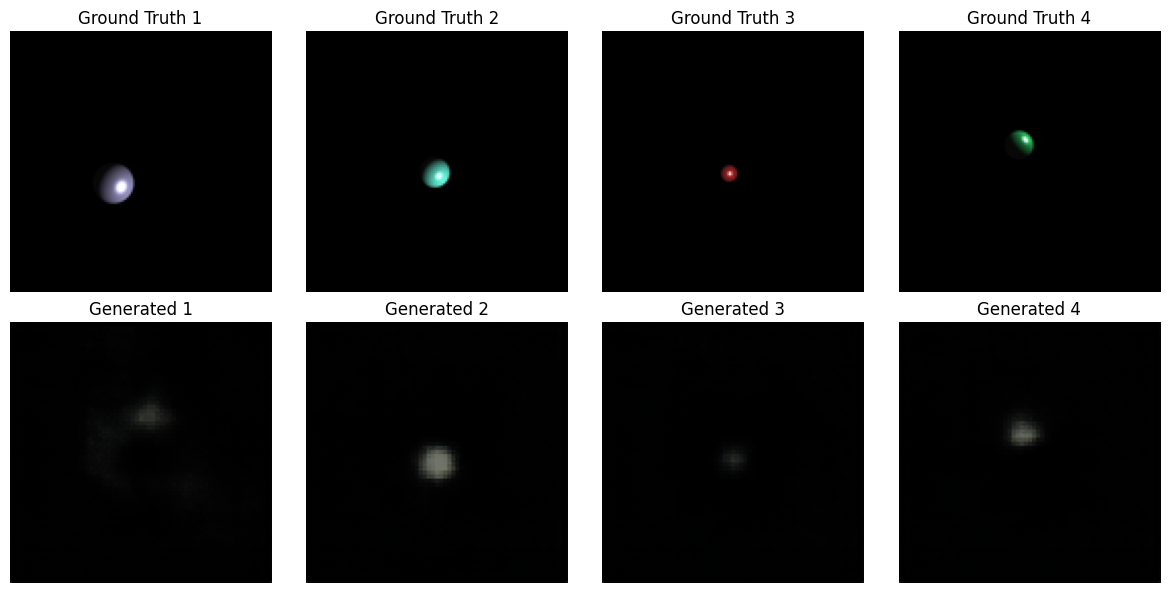

Epoch [41/500], Train Loss: 0.0046, Val Loss: 0.0065, Val FLIP: 0.0366, LR: 0.001000
Saved best model at epoch 41 with FLIP 0.0366
Epoch [42/500], Train Loss: 0.0044, Val Loss: 0.0064, Val FLIP: 0.0353, LR: 0.001000
Saved best model at epoch 42 with FLIP 0.0353
Epoch [43/500], Train Loss: 0.0043, Val Loss: 0.0063, Val FLIP: 0.0358, LR: 0.001000
Epoch [44/500], Train Loss: 0.0043, Val Loss: 0.0064, Val FLIP: 0.0348, LR: 0.001000
Saved best model at epoch 44 with FLIP 0.0348
Epoch [45/500], Train Loss: 0.0041, Val Loss: 0.0065, Val FLIP: 0.0381, LR: 0.001000
Epoch [46/500], Train Loss: 0.0040, Val Loss: 0.0062, Val FLIP: 0.0352, LR: 0.001000
Epoch [47/500], Train Loss: 0.0038, Val Loss: 0.0062, Val FLIP: 0.0346, LR: 0.001000
Saved best model at epoch 47 with FLIP 0.0346
Epoch [48/500], Train Loss: 0.0037, Val Loss: 0.0063, Val FLIP: 0.0354, LR: 0.001000
Epoch [49/500], Train Loss: 0.0036, Val Loss: 0.0060, Val FLIP: 0.0336, LR: 0.001000
Saved best model at epoch 49 with FLIP 0.0336
Epoch

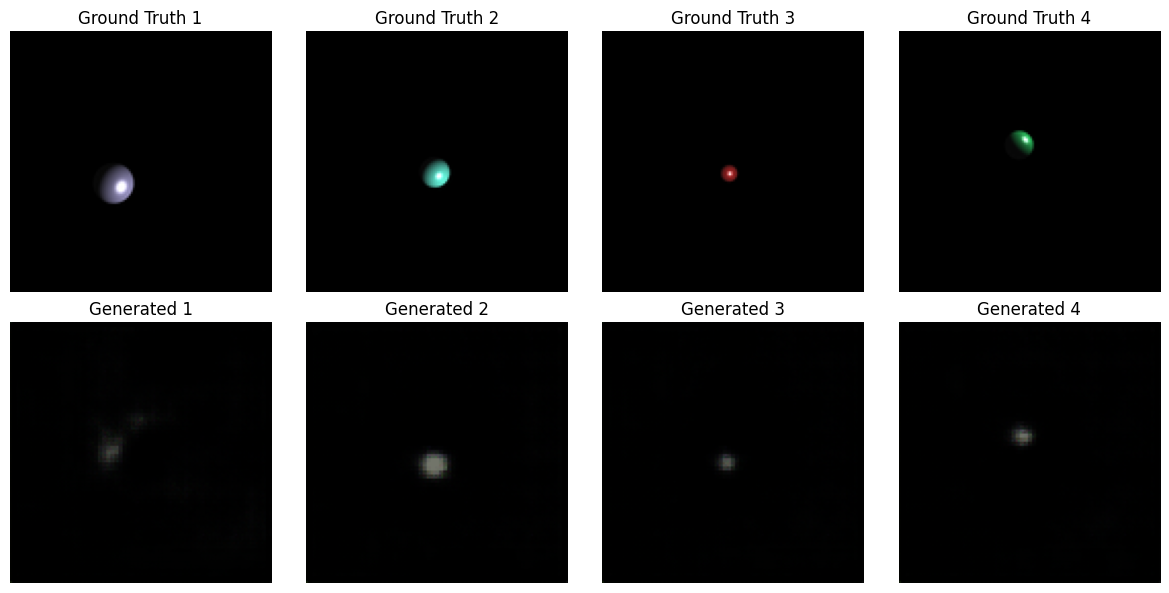

Epoch [51/500], Train Loss: 0.0035, Val Loss: 0.0059, Val FLIP: 0.0330, LR: 0.001000
Saved best model at epoch 51 with FLIP 0.0330
Epoch [52/500], Train Loss: 0.0034, Val Loss: 0.0064, Val FLIP: 0.0342, LR: 0.001000
Epoch [53/500], Train Loss: 0.0033, Val Loss: 0.0061, Val FLIP: 0.0324, LR: 0.001000
Saved best model at epoch 53 with FLIP 0.0324
Epoch [54/500], Train Loss: 0.0033, Val Loss: 0.0061, Val FLIP: 0.0317, LR: 0.001000
Saved best model at epoch 54 with FLIP 0.0317
Epoch [55/500], Train Loss: 0.0032, Val Loss: 0.0059, Val FLIP: 0.0310, LR: 0.001000
Saved best model at epoch 55 with FLIP 0.0310
Epoch [56/500], Train Loss: 0.0031, Val Loss: 0.0062, Val FLIP: 0.0316, LR: 0.001000
Epoch [57/500], Train Loss: 0.0031, Val Loss: 0.0059, Val FLIP: 0.0302, LR: 0.001000
Saved best model at epoch 57 with FLIP 0.0302
Epoch [58/500], Train Loss: 0.0030, Val Loss: 0.0060, Val FLIP: 0.0299, LR: 0.001000
Saved best model at epoch 58 with FLIP 0.0299
Epoch [59/500], Train Loss: 0.0030, Val Loss

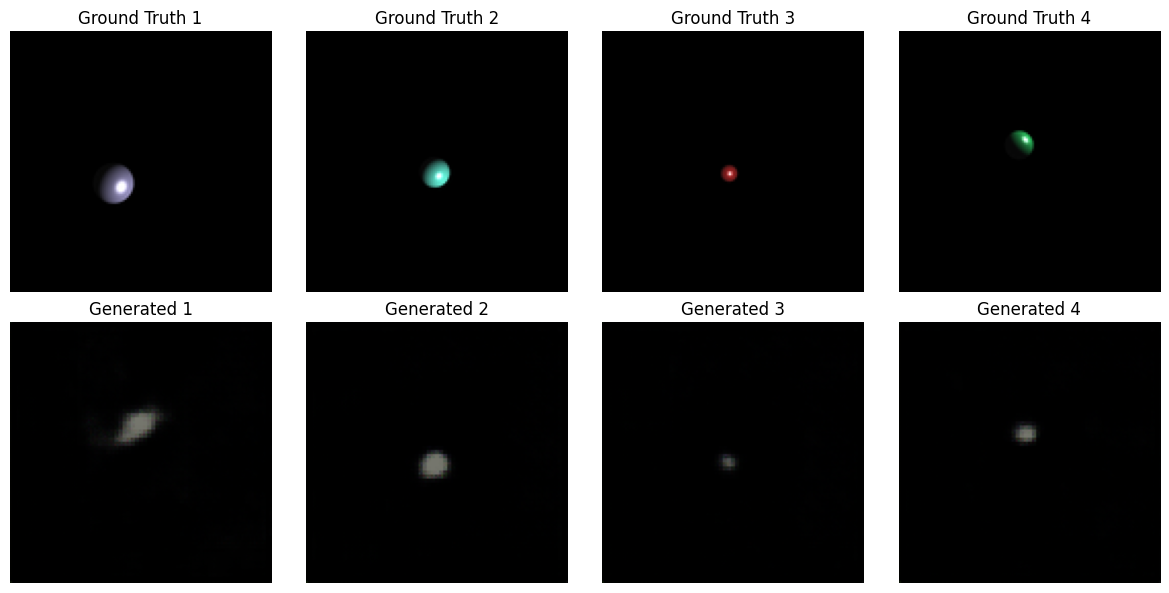

Epoch [61/500], Train Loss: 0.0028, Val Loss: 0.0059, Val FLIP: 0.0289, LR: 0.001000
Saved best model at epoch 61 with FLIP 0.0289
Epoch [62/500], Train Loss: 0.0028, Val Loss: 0.0058, Val FLIP: 0.0283, LR: 0.001000
Saved best model at epoch 62 with FLIP 0.0283
Epoch [63/500], Train Loss: 0.0028, Val Loss: 0.0059, Val FLIP: 0.0270, LR: 0.001000
Saved best model at epoch 63 with FLIP 0.0270
Epoch [64/500], Train Loss: 0.0028, Val Loss: 0.0059, Val FLIP: 0.0286, LR: 0.001000
Epoch [65/500], Train Loss: 0.0027, Val Loss: 0.0058, Val FLIP: 0.0275, LR: 0.001000
Epoch [66/500], Train Loss: 0.0027, Val Loss: 0.0057, Val FLIP: 0.0266, LR: 0.001000
Saved best model at epoch 66 with FLIP 0.0266
Epoch [67/500], Train Loss: 0.0026, Val Loss: 0.0060, Val FLIP: 0.0283, LR: 0.001000
Epoch [68/500], Train Loss: 0.0026, Val Loss: 0.0058, Val FLIP: 0.0264, LR: 0.001000
Saved best model at epoch 68 with FLIP 0.0264
Epoch [69/500], Train Loss: 0.0026, Val Loss: 0.0058, Val FLIP: 0.0269, LR: 0.001000
Epoch

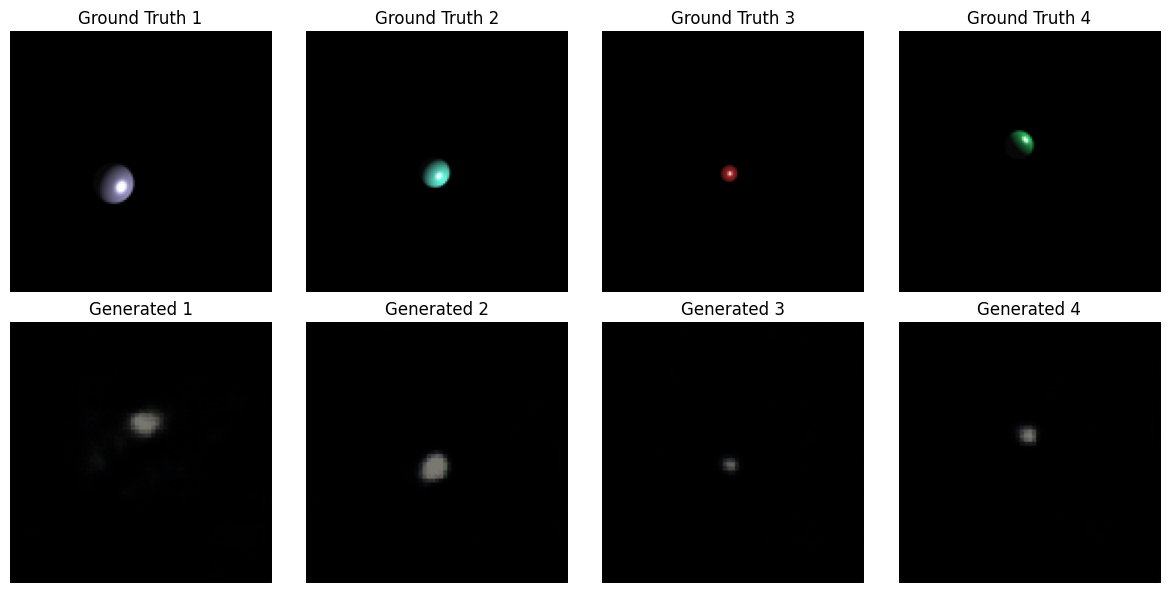

Epoch [71/500], Train Loss: 0.0025, Val Loss: 0.0059, Val FLIP: 0.0264, LR: 0.001000
Epoch [72/500], Train Loss: 0.0025, Val Loss: 0.0058, Val FLIP: 0.0263, LR: 0.001000
Epoch [73/500], Train Loss: 0.0025, Val Loss: 0.0057, Val FLIP: 0.0254, LR: 0.001000
Saved best model at epoch 73 with FLIP 0.0254
Epoch [74/500], Train Loss: 0.0024, Val Loss: 0.0058, Val FLIP: 0.0255, LR: 0.001000
Epoch [75/500], Train Loss: 0.0025, Val Loss: 0.0059, Val FLIP: 0.0261, LR: 0.001000
Epoch [76/500], Train Loss: 0.0024, Val Loss: 0.0058, Val FLIP: 0.0261, LR: 0.001000
Epoch [77/500], Train Loss: 0.0024, Val Loss: 0.0056, Val FLIP: 0.0252, LR: 0.001000
Saved best model at epoch 77 with FLIP 0.0252
Epoch [78/500], Train Loss: 0.0024, Val Loss: 0.0058, Val FLIP: 0.0250, LR: 0.001000
Saved best model at epoch 78 with FLIP 0.0250
Epoch [79/500], Train Loss: 0.0024, Val Loss: 0.0058, Val FLIP: 0.0251, LR: 0.001000
Epoch [80/500], Train Loss: 0.0023, Val Loss: 0.0059, Val FLIP: 0.0248, LR: 0.001000
Saved best m

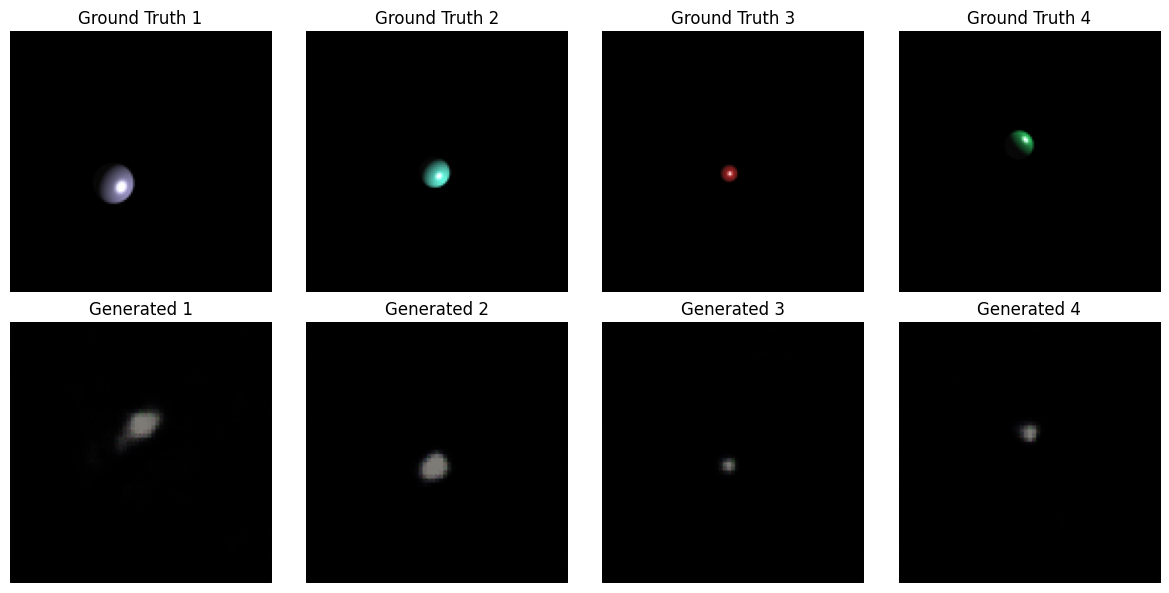

Epoch [81/500], Train Loss: 0.0023, Val Loss: 0.0059, Val FLIP: 0.0248, LR: 0.001000
Epoch [82/500], Train Loss: 0.0023, Val Loss: 0.0057, Val FLIP: 0.0245, LR: 0.001000
Saved best model at epoch 82 with FLIP 0.0245
Epoch [83/500], Train Loss: 0.0022, Val Loss: 0.0059, Val FLIP: 0.0250, LR: 0.001000
Epoch [84/500], Train Loss: 0.0022, Val Loss: 0.0056, Val FLIP: 0.0239, LR: 0.001000
Saved best model at epoch 84 with FLIP 0.0239
Epoch [85/500], Train Loss: 0.0022, Val Loss: 0.0058, Val FLIP: 0.0239, LR: 0.001000
Epoch [86/500], Train Loss: 0.0022, Val Loss: 0.0057, Val FLIP: 0.0240, LR: 0.001000
Epoch [87/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0239, LR: 0.001000
Epoch [88/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0231, LR: 0.001000
Saved best model at epoch 88 with FLIP 0.0231
Epoch [89/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0237, LR: 0.001000
Epoch [90/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0230, LR: 0.001000
Saved best m

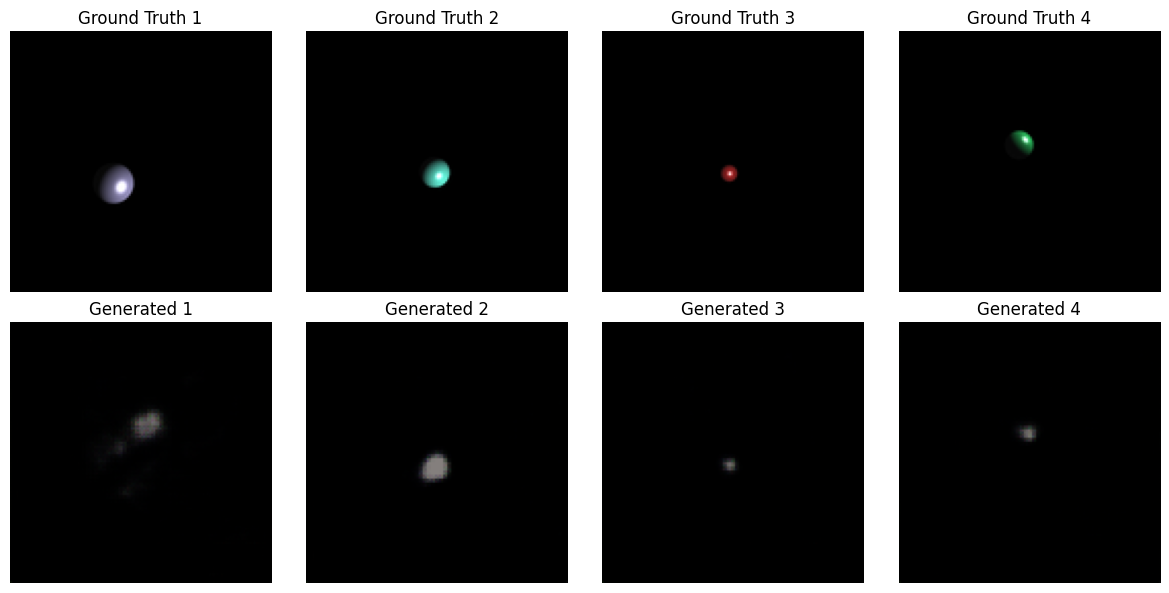

Epoch [91/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0235, LR: 0.001000
Epoch [92/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0230, LR: 0.001000
Saved best model at epoch 92 with FLIP 0.0230
Epoch [93/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0234, LR: 0.001000
Epoch [94/500], Train Loss: 0.0021, Val Loss: 0.0058, Val FLIP: 0.0233, LR: 0.001000
Epoch [95/500], Train Loss: 0.0021, Val Loss: 0.0056, Val FLIP: 0.0219, LR: 0.001000
Saved best model at epoch 95 with FLIP 0.0219
Epoch [96/500], Train Loss: 0.0022, Val Loss: 0.0058, Val FLIP: 0.0240, LR: 0.001000
Epoch [97/500], Train Loss: 0.0021, Val Loss: 0.0057, Val FLIP: 0.0227, LR: 0.001000
Epoch [98/500], Train Loss: 0.0021, Val Loss: 0.0058, Val FLIP: 0.0232, LR: 0.001000
Epoch [99/500], Train Loss: 0.0020, Val Loss: 0.0057, Val FLIP: 0.0224, LR: 0.001000
Epoch [100/500], Train Loss: 0.0020, Val Loss: 0.0056, Val FLIP: 0.0221, LR: 0.001000


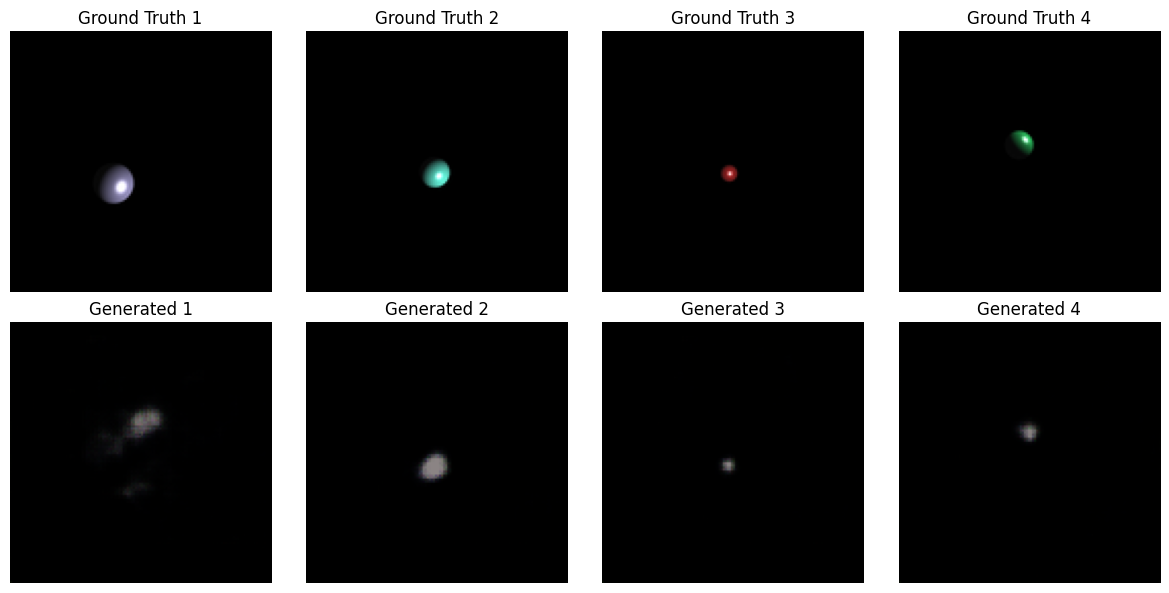

Epoch [101/500], Train Loss: 0.0019, Val Loss: 0.0056, Val FLIP: 0.0224, LR: 0.000500
Epoch [102/500], Train Loss: 0.0018, Val Loss: 0.0056, Val FLIP: 0.0224, LR: 0.000500
Epoch [103/500], Train Loss: 0.0018, Val Loss: 0.0056, Val FLIP: 0.0223, LR: 0.000500
Epoch [104/500], Train Loss: 0.0018, Val Loss: 0.0057, Val FLIP: 0.0226, LR: 0.000500
Epoch [105/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0224, LR: 0.000500
Epoch [106/500], Train Loss: 0.0017, Val Loss: 0.0057, Val FLIP: 0.0225, LR: 0.000500
Epoch [107/500], Train Loss: 0.0017, Val Loss: 0.0057, Val FLIP: 0.0222, LR: 0.000500
Epoch [108/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0222, LR: 0.000500
Epoch [109/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0222, LR: 0.000500
Epoch [110/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0221, LR: 0.000500


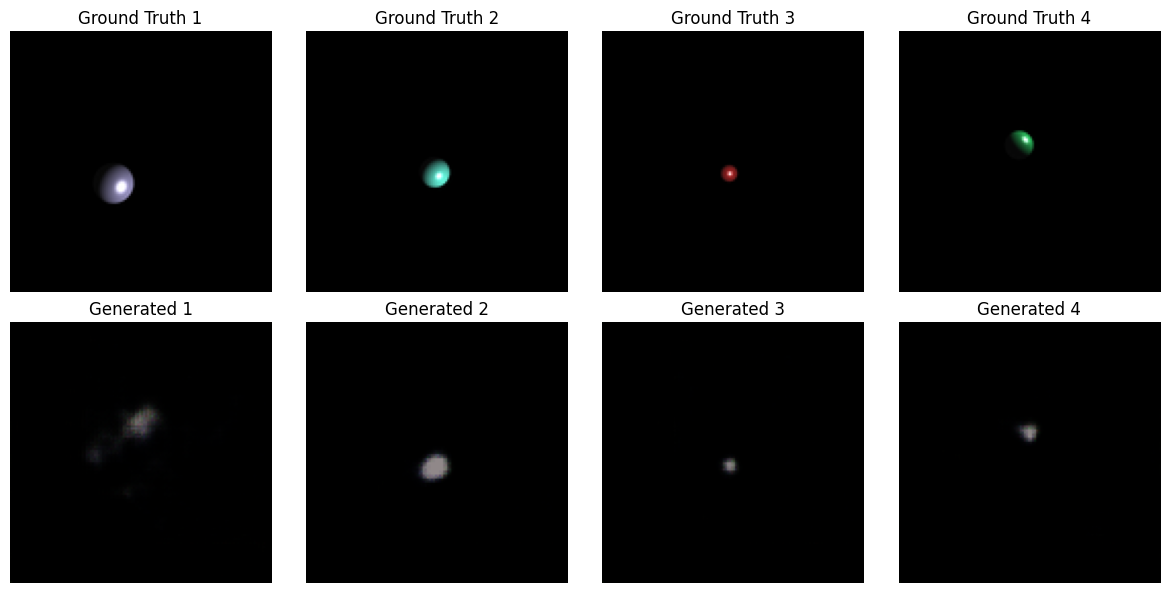

Epoch [111/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0219, LR: 0.000500
Epoch [112/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0218, LR: 0.000500
Saved best model at epoch 112 with FLIP 0.0218
Epoch [113/500], Train Loss: 0.0017, Val Loss: 0.0056, Val FLIP: 0.0221, LR: 0.000500
Epoch [114/500], Train Loss: 0.0017, Val Loss: 0.0057, Val FLIP: 0.0217, LR: 0.000500
Saved best model at epoch 114 with FLIP 0.0217
Epoch [115/500], Train Loss: 0.0017, Val Loss: 0.0057, Val FLIP: 0.0219, LR: 0.000500
Epoch [116/500], Train Loss: 0.0016, Val Loss: 0.0056, Val FLIP: 0.0218, LR: 0.000500
Epoch [117/500], Train Loss: 0.0016, Val Loss: 0.0057, Val FLIP: 0.0221, LR: 0.000500
Epoch [118/500], Train Loss: 0.0016, Val Loss: 0.0056, Val FLIP: 0.0215, LR: 0.000500
Saved best model at epoch 118 with FLIP 0.0215
Epoch [119/500], Train Loss: 0.0016, Val Loss: 0.0056, Val FLIP: 0.0217, LR: 0.000500
Epoch [120/500], Train Loss: 0.0016, Val Loss: 0.0056, Val FLIP: 0.0217, LR: 0.000500

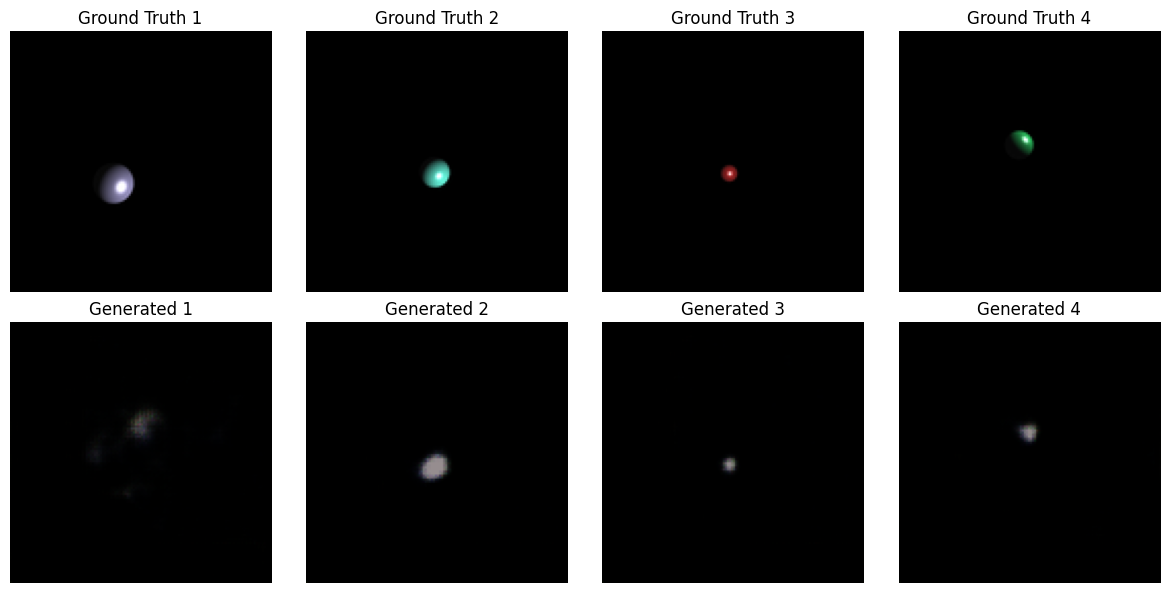

Epoch [121/500], Train Loss: 0.0016, Val Loss: 0.0058, Val FLIP: 0.0218, LR: 0.000500
Epoch [122/500], Train Loss: 0.0016, Val Loss: 0.0057, Val FLIP: 0.0213, LR: 0.000500
Saved best model at epoch 122 with FLIP 0.0213
Epoch [123/500], Train Loss: 0.0016, Val Loss: 0.0058, Val FLIP: 0.0217, LR: 0.000500
Epoch [124/500], Train Loss: 0.0016, Val Loss: 0.0057, Val FLIP: 0.0215, LR: 0.000500
Epoch [125/500], Train Loss: 0.0016, Val Loss: 0.0057, Val FLIP: 0.0213, LR: 0.000500
Saved best model at epoch 125 with FLIP 0.0213
Epoch [126/500], Train Loss: 0.0016, Val Loss: 0.0056, Val FLIP: 0.0210, LR: 0.000500
Saved best model at epoch 126 with FLIP 0.0210
Epoch [127/500], Train Loss: 0.0015, Val Loss: 0.0057, Val FLIP: 0.0216, LR: 0.000500
Epoch [128/500], Train Loss: 0.0015, Val Loss: 0.0057, Val FLIP: 0.0212, LR: 0.000500
Epoch [129/500], Train Loss: 0.0015, Val Loss: 0.0056, Val FLIP: 0.0209, LR: 0.000500
Saved best model at epoch 129 with FLIP 0.0209
Epoch [130/500], Train Loss: 0.0015, V

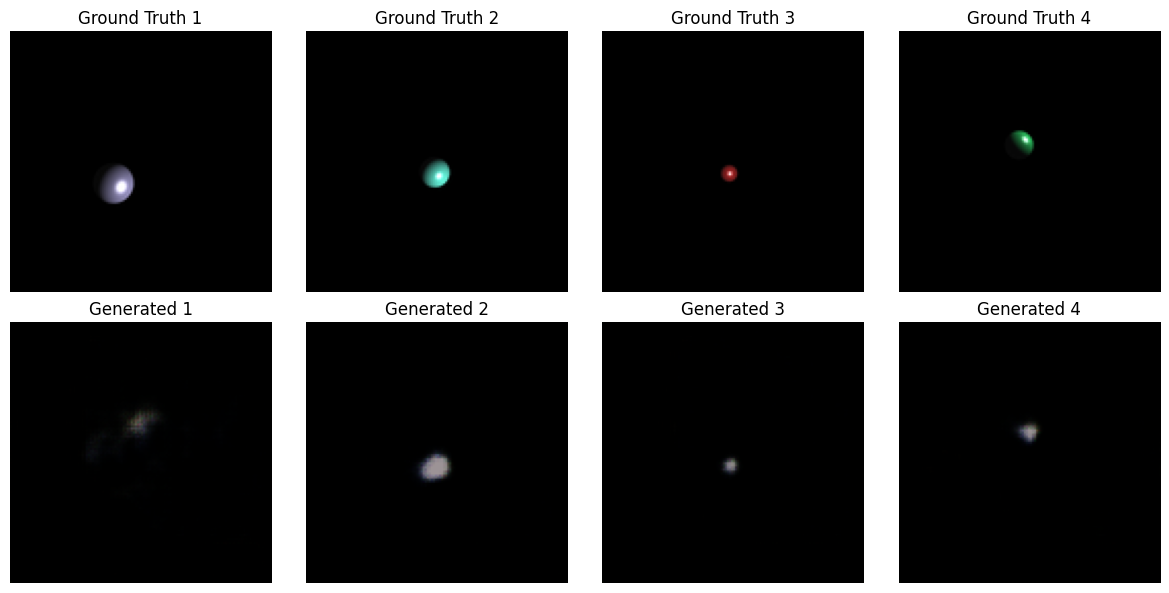

Epoch [131/500], Train Loss: 0.0015, Val Loss: 0.0056, Val FLIP: 0.0208, LR: 0.000500
Saved best model at epoch 131 with FLIP 0.0208
Epoch [132/500], Train Loss: 0.0015, Val Loss: 0.0056, Val FLIP: 0.0211, LR: 0.000500
Epoch [133/500], Train Loss: 0.0015, Val Loss: 0.0058, Val FLIP: 0.0214, LR: 0.000500
Epoch [134/500], Train Loss: 0.0015, Val Loss: 0.0058, Val FLIP: 0.0213, LR: 0.000500
Epoch [135/500], Train Loss: 0.0015, Val Loss: 0.0056, Val FLIP: 0.0213, LR: 0.000500
Epoch [136/500], Train Loss: 0.0015, Val Loss: 0.0056, Val FLIP: 0.0208, LR: 0.000500
Saved best model at epoch 136 with FLIP 0.0208
Epoch [137/500], Train Loss: 0.0015, Val Loss: 0.0057, Val FLIP: 0.0215, LR: 0.000500
Epoch [138/500], Train Loss: 0.0014, Val Loss: 0.0057, Val FLIP: 0.0210, LR: 0.000500
Epoch [139/500], Train Loss: 0.0014, Val Loss: 0.0057, Val FLIP: 0.0210, LR: 0.000500
Epoch [140/500], Train Loss: 0.0014, Val Loss: 0.0056, Val FLIP: 0.0208, LR: 0.000500
Saved best model at epoch 140 with FLIP 0.0208

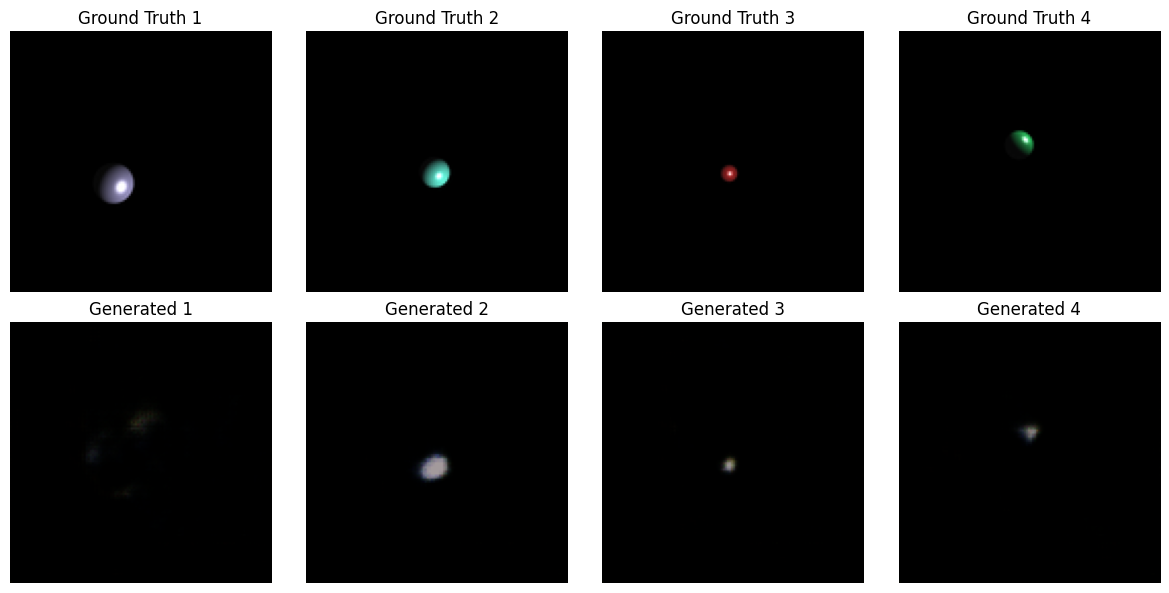

Epoch [141/500], Train Loss: 0.0014, Val Loss: 0.0056, Val FLIP: 0.0210, LR: 0.000500
Epoch [142/500], Train Loss: 0.0014, Val Loss: 0.0057, Val FLIP: 0.0208, LR: 0.000500
Epoch [143/500], Train Loss: 0.0014, Val Loss: 0.0056, Val FLIP: 0.0206, LR: 0.000500
Saved best model at epoch 143 with FLIP 0.0206
Epoch [144/500], Train Loss: 0.0014, Val Loss: 0.0056, Val FLIP: 0.0209, LR: 0.000500
Epoch [145/500], Train Loss: 0.0013, Val Loss: 0.0057, Val FLIP: 0.0210, LR: 0.000500
Epoch [146/500], Train Loss: 0.0013, Val Loss: 0.0058, Val FLIP: 0.0210, LR: 0.000500
Epoch [147/500], Train Loss: 0.0013, Val Loss: 0.0056, Val FLIP: 0.0198, LR: 0.000500
Saved best model at epoch 147 with FLIP 0.0198
Epoch [148/500], Train Loss: 0.0013, Val Loss: 0.0057, Val FLIP: 0.0204, LR: 0.000500
Epoch [149/500], Train Loss: 0.0013, Val Loss: 0.0056, Val FLIP: 0.0206, LR: 0.000500
Epoch [150/500], Train Loss: 0.0013, Val Loss: 0.0055, Val FLIP: 0.0208, LR: 0.000500


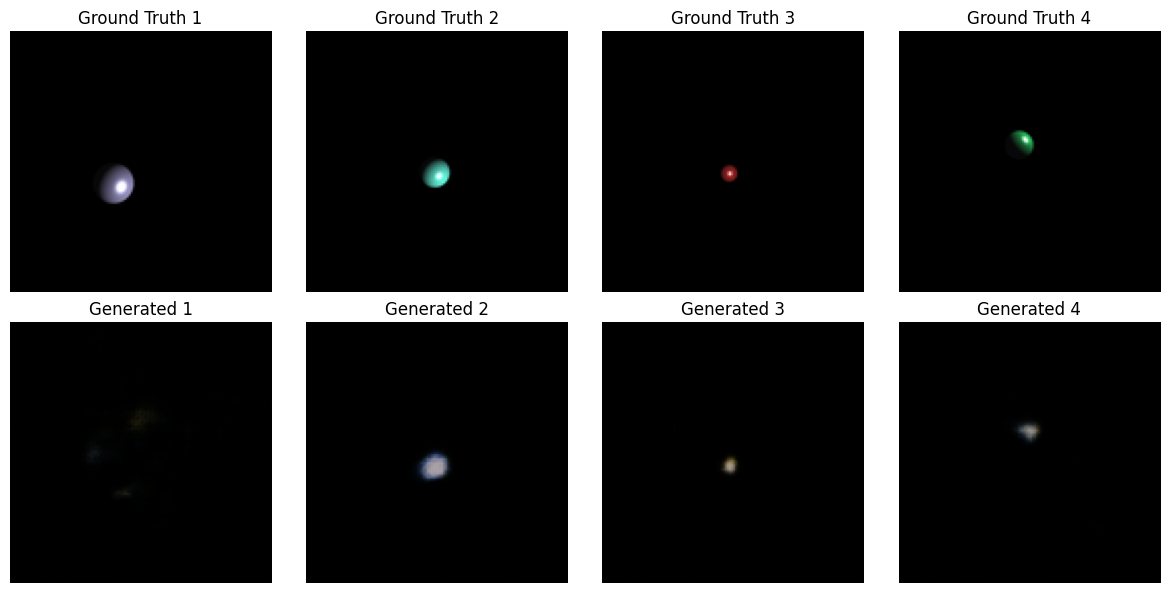

Epoch [151/500], Train Loss: 0.0012, Val Loss: 0.0057, Val FLIP: 0.0209, LR: 0.000500
Epoch [152/500], Train Loss: 0.0012, Val Loss: 0.0056, Val FLIP: 0.0207, LR: 0.000500
Epoch [153/500], Train Loss: 0.0012, Val Loss: 0.0057, Val FLIP: 0.0211, LR: 0.000500
Epoch [154/500], Train Loss: 0.0012, Val Loss: 0.0056, Val FLIP: 0.0205, LR: 0.000500
Epoch [155/500], Train Loss: 0.0012, Val Loss: 0.0057, Val FLIP: 0.0203, LR: 0.000500
Epoch [156/500], Train Loss: 0.0012, Val Loss: 0.0056, Val FLIP: 0.0203, LR: 0.000500
Epoch [157/500], Train Loss: 0.0012, Val Loss: 0.0058, Val FLIP: 0.0203, LR: 0.000500
Epoch [158/500], Train Loss: 0.0012, Val Loss: 0.0056, Val FLIP: 0.0207, LR: 0.000500
Epoch [159/500], Train Loss: 0.0011, Val Loss: 0.0055, Val FLIP: 0.0201, LR: 0.000500
Epoch [160/500], Train Loss: 0.0011, Val Loss: 0.0055, Val FLIP: 0.0202, LR: 0.000500


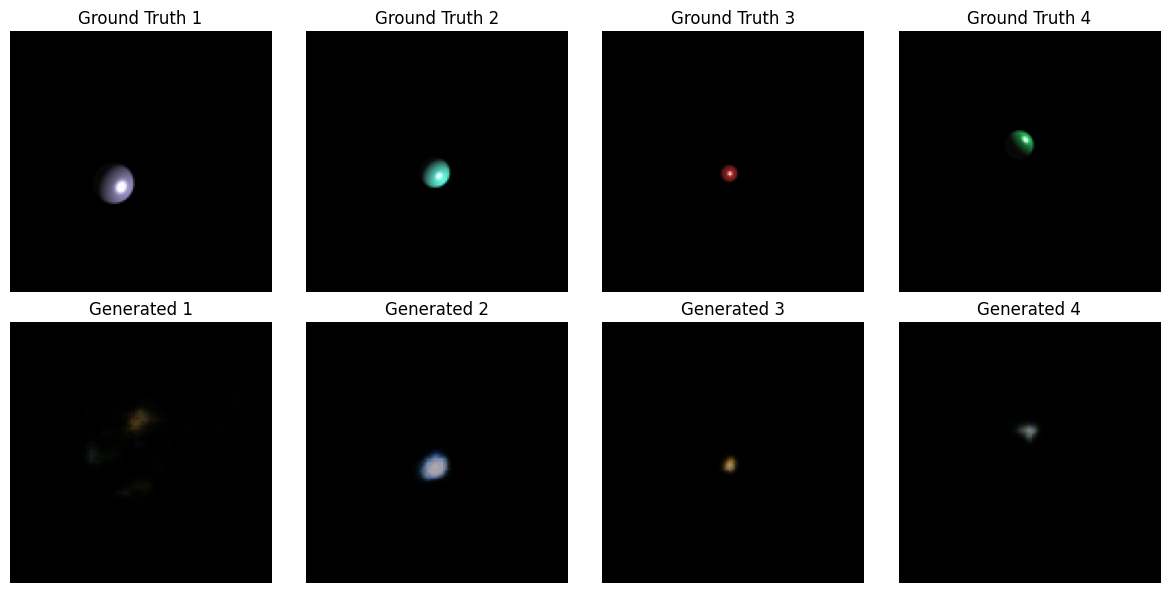

Epoch [161/500], Train Loss: 0.0011, Val Loss: 0.0056, Val FLIP: 0.0205, LR: 0.000500
Epoch [162/500], Train Loss: 0.0011, Val Loss: 0.0056, Val FLIP: 0.0199, LR: 0.000500
Epoch [163/500], Train Loss: 0.0011, Val Loss: 0.0056, Val FLIP: 0.0195, LR: 0.000500
Saved best model at epoch 163 with FLIP 0.0195
Epoch [164/500], Train Loss: 0.0011, Val Loss: 0.0057, Val FLIP: 0.0202, LR: 0.000500
Epoch [165/500], Train Loss: 0.0011, Val Loss: 0.0057, Val FLIP: 0.0201, LR: 0.000500
Epoch [166/500], Train Loss: 0.0011, Val Loss: 0.0056, Val FLIP: 0.0196, LR: 0.000500
Epoch [167/500], Train Loss: 0.0010, Val Loss: 0.0057, Val FLIP: 0.0202, LR: 0.000500
Epoch [168/500], Train Loss: 0.0010, Val Loss: 0.0055, Val FLIP: 0.0194, LR: 0.000500
Saved best model at epoch 168 with FLIP 0.0194
Epoch [169/500], Train Loss: 0.0010, Val Loss: 0.0058, Val FLIP: 0.0196, LR: 0.000500
Epoch [170/500], Train Loss: 0.0010, Val Loss: 0.0056, Val FLIP: 0.0189, LR: 0.000500
Saved best model at epoch 170 with FLIP 0.0189

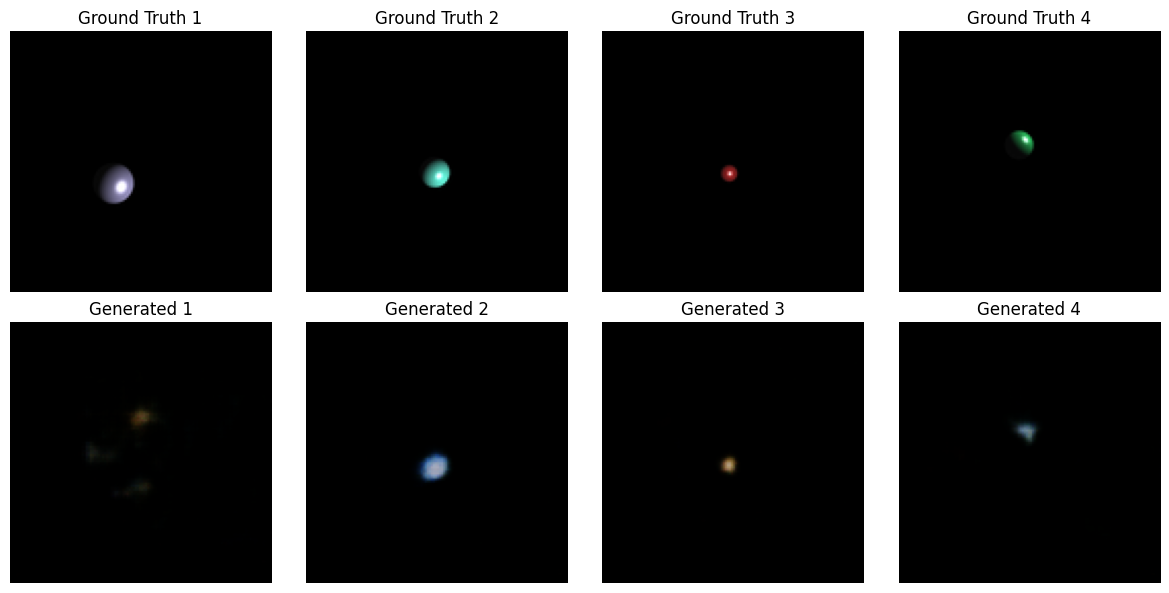

Epoch [171/500], Train Loss: 0.0010, Val Loss: 0.0057, Val FLIP: 0.0198, LR: 0.000500
Epoch [172/500], Train Loss: 0.0010, Val Loss: 0.0058, Val FLIP: 0.0196, LR: 0.000500
Epoch [173/500], Train Loss: 0.0010, Val Loss: 0.0058, Val FLIP: 0.0200, LR: 0.000500
Epoch [174/500], Train Loss: 0.0009, Val Loss: 0.0056, Val FLIP: 0.0192, LR: 0.000500
Epoch [175/500], Train Loss: 0.0009, Val Loss: 0.0056, Val FLIP: 0.0187, LR: 0.000500
Saved best model at epoch 175 with FLIP 0.0187
Epoch [176/500], Train Loss: 0.0009, Val Loss: 0.0056, Val FLIP: 0.0187, LR: 0.000500
Epoch [177/500], Train Loss: 0.0009, Val Loss: 0.0057, Val FLIP: 0.0190, LR: 0.000500
Epoch [178/500], Train Loss: 0.0009, Val Loss: 0.0057, Val FLIP: 0.0182, LR: 0.000500
Saved best model at epoch 178 with FLIP 0.0182
Epoch [179/500], Train Loss: 0.0009, Val Loss: 0.0057, Val FLIP: 0.0186, LR: 0.000500
Epoch [180/500], Train Loss: 0.0009, Val Loss: 0.0056, Val FLIP: 0.0184, LR: 0.000500


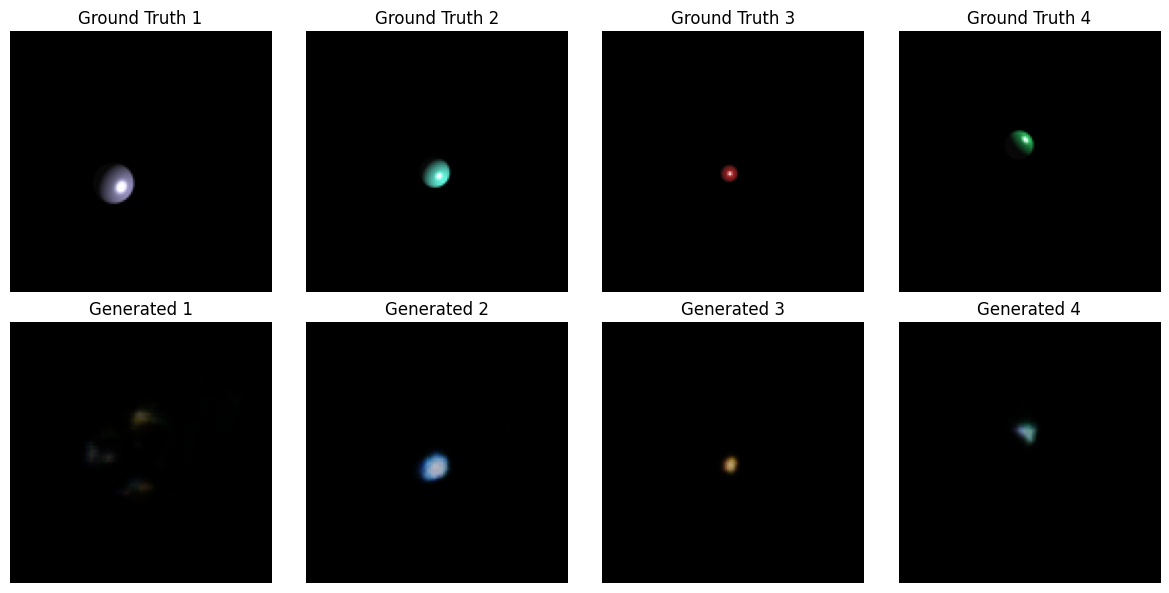

Epoch [181/500], Train Loss: 0.0009, Val Loss: 0.0059, Val FLIP: 0.0188, LR: 0.000500
Epoch [182/500], Train Loss: 0.0008, Val Loss: 0.0057, Val FLIP: 0.0186, LR: 0.000500
Epoch [183/500], Train Loss: 0.0008, Val Loss: 0.0057, Val FLIP: 0.0184, LR: 0.000500
Epoch [184/500], Train Loss: 0.0008, Val Loss: 0.0058, Val FLIP: 0.0181, LR: 0.000500
Saved best model at epoch 184 with FLIP 0.0181
Epoch [185/500], Train Loss: 0.0008, Val Loss: 0.0057, Val FLIP: 0.0179, LR: 0.000500
Saved best model at epoch 185 with FLIP 0.0179
Epoch [186/500], Train Loss: 0.0008, Val Loss: 0.0057, Val FLIP: 0.0179, LR: 0.000500
Saved best model at epoch 186 with FLIP 0.0179
Epoch [187/500], Train Loss: 0.0007, Val Loss: 0.0056, Val FLIP: 0.0179, LR: 0.000500
Epoch [188/500], Train Loss: 0.0007, Val Loss: 0.0057, Val FLIP: 0.0179, LR: 0.000500
Epoch [189/500], Train Loss: 0.0007, Val Loss: 0.0056, Val FLIP: 0.0176, LR: 0.000500
Saved best model at epoch 189 with FLIP 0.0176
Epoch [190/500], Train Loss: 0.0007, V

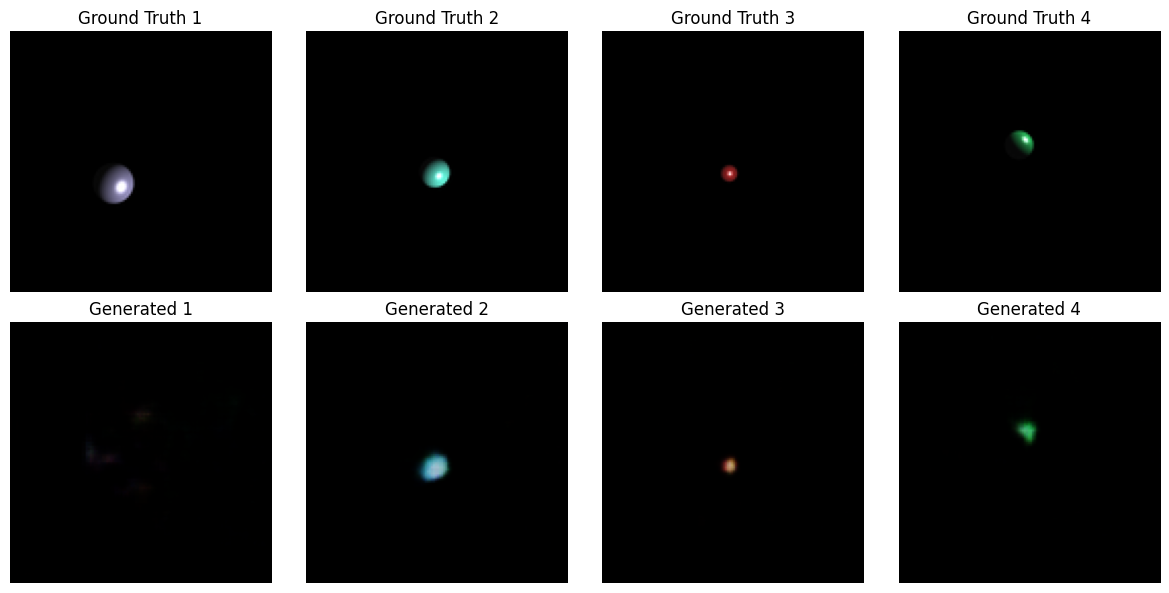

Epoch [191/500], Train Loss: 0.0007, Val Loss: 0.0056, Val FLIP: 0.0175, LR: 0.000500
Saved best model at epoch 191 with FLIP 0.0175
Epoch [192/500], Train Loss: 0.0007, Val Loss: 0.0056, Val FLIP: 0.0173, LR: 0.000500
Saved best model at epoch 192 with FLIP 0.0173
Epoch [193/500], Train Loss: 0.0007, Val Loss: 0.0056, Val FLIP: 0.0171, LR: 0.000500
Saved best model at epoch 193 with FLIP 0.0171
Epoch [194/500], Train Loss: 0.0006, Val Loss: 0.0056, Val FLIP: 0.0169, LR: 0.000500
Saved best model at epoch 194 with FLIP 0.0169
Epoch [195/500], Train Loss: 0.0006, Val Loss: 0.0057, Val FLIP: 0.0173, LR: 0.000500
Epoch [196/500], Train Loss: 0.0006, Val Loss: 0.0055, Val FLIP: 0.0168, LR: 0.000500
Saved best model at epoch 196 with FLIP 0.0168
Epoch [197/500], Train Loss: 0.0006, Val Loss: 0.0055, Val FLIP: 0.0167, LR: 0.000500
Saved best model at epoch 197 with FLIP 0.0167
Epoch [198/500], Train Loss: 0.0006, Val Loss: 0.0057, Val FLIP: 0.0166, LR: 0.000500
Saved best model at epoch 198 

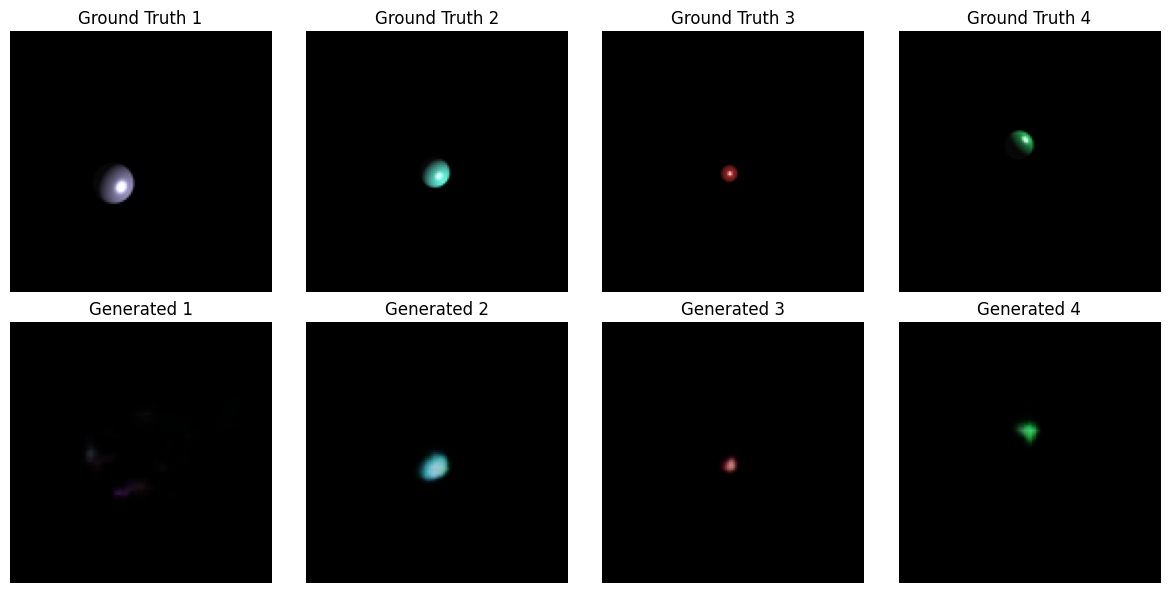

Epoch [201/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0168, LR: 0.000250
Epoch [202/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0166, LR: 0.000250
Saved best model at epoch 202 with FLIP 0.0166
Epoch [203/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0166, LR: 0.000250
Saved best model at epoch 203 with FLIP 0.0166
Epoch [204/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0164, LR: 0.000250
Saved best model at epoch 204 with FLIP 0.0164
Epoch [205/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0164, LR: 0.000250
Saved best model at epoch 205 with FLIP 0.0164
Epoch [206/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0163, LR: 0.000250
Saved best model at epoch 206 with FLIP 0.0163
Epoch [207/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0163, LR: 0.000250
Saved best model at epoch 207 with FLIP 0.0163
Epoch [208/500], Train Loss: 0.0005, Val Loss: 0.0057, Val FLIP: 0.0162, LR: 0.000250
Saved best model at epoch 208 

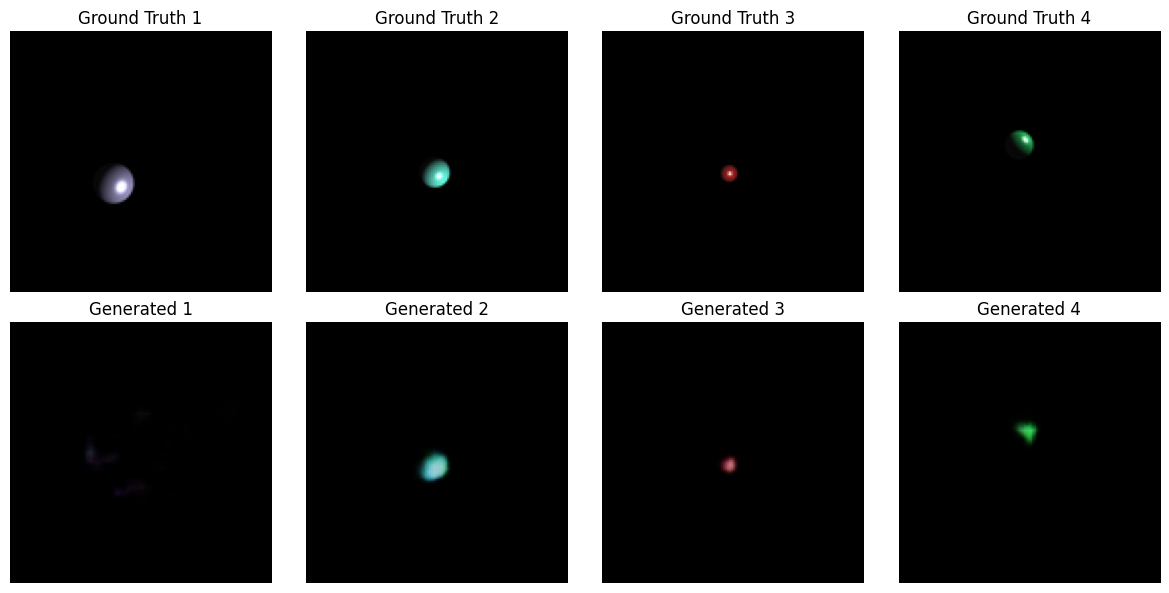

Epoch [211/500], Train Loss: 0.0005, Val Loss: 0.0056, Val FLIP: 0.0161, LR: 0.000250
Epoch [212/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0159, LR: 0.000250
Saved best model at epoch 212 with FLIP 0.0159
Epoch [213/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0160, LR: 0.000250
Epoch [214/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0159, LR: 0.000250
Epoch [215/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0159, LR: 0.000250
Epoch [216/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0159, LR: 0.000250
Epoch [217/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0157, LR: 0.000250
Saved best model at epoch 217 with FLIP 0.0157
Epoch [218/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0157, LR: 0.000250
Epoch [219/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0158, LR: 0.000250
Epoch [220/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0157, LR: 0.000250
Saved best model at epoch 220 with FLIP 0.0157

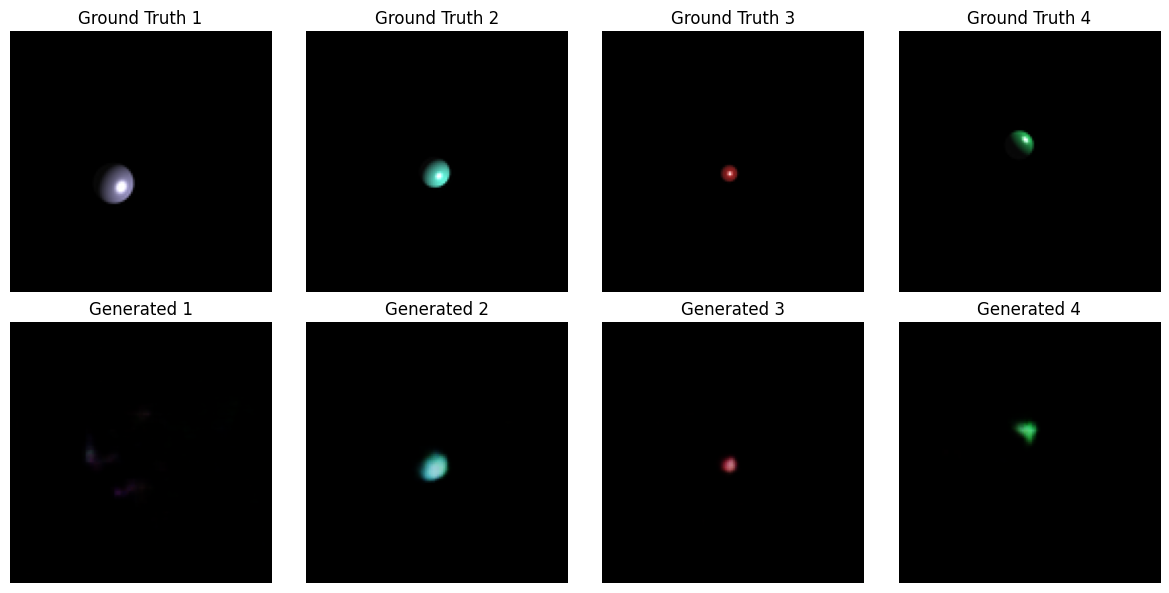

Epoch [221/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0156, LR: 0.000250
Saved best model at epoch 221 with FLIP 0.0156
Epoch [222/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0155, LR: 0.000250
Saved best model at epoch 222 with FLIP 0.0155
Epoch [223/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0155, LR: 0.000250
Epoch [224/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0155, LR: 0.000250
Epoch [225/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0153, LR: 0.000250
Saved best model at epoch 225 with FLIP 0.0153
Epoch [226/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0153, LR: 0.000250
Saved best model at epoch 226 with FLIP 0.0153
Epoch [227/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0155, LR: 0.000250
Epoch [228/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0154, LR: 0.000250
Epoch [229/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0154, LR: 0.000250
Epoch [230/500], Train Loss: 0.0004, V

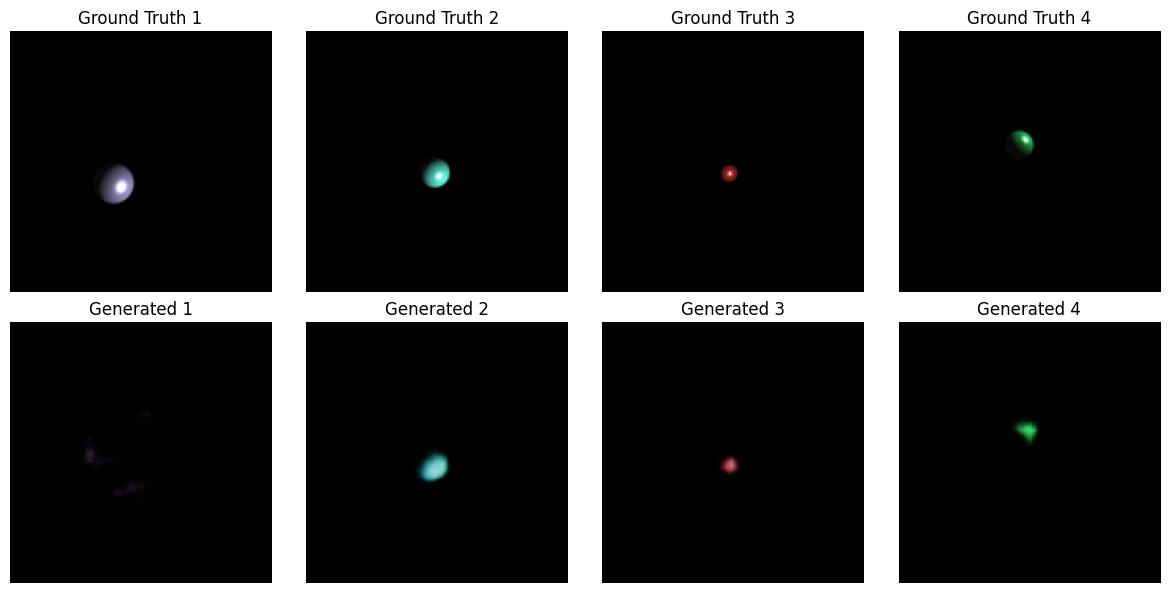

Epoch [231/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0153, LR: 0.000250
Saved best model at epoch 231 with FLIP 0.0153
Epoch [232/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0151, LR: 0.000250
Saved best model at epoch 232 with FLIP 0.0151
Epoch [233/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0152, LR: 0.000250
Epoch [234/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0150, LR: 0.000250
Saved best model at epoch 234 with FLIP 0.0150
Epoch [235/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0151, LR: 0.000250
Epoch [236/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0152, LR: 0.000250
Epoch [237/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0151, LR: 0.000250
Epoch [238/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0150, LR: 0.000250
Saved best model at epoch 238 with FLIP 0.0150
Epoch [239/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0151, LR: 0.000250
Epoch [240/500], Train Loss: 0.0004, V

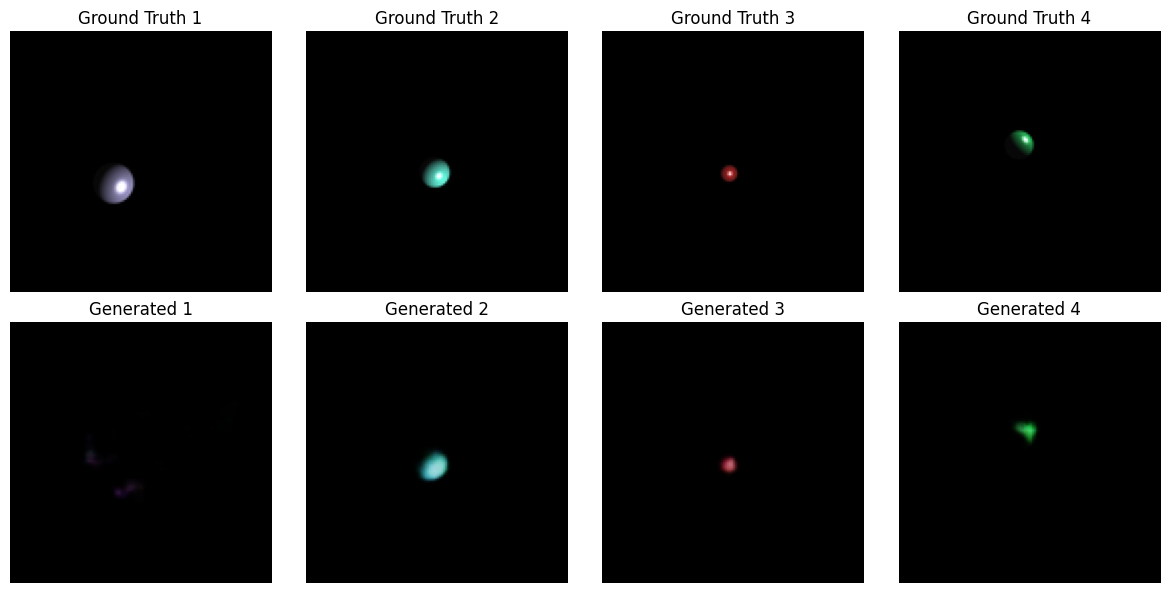

Epoch [241/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0150, LR: 0.000250
Epoch [242/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0148, LR: 0.000250
Epoch [243/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0146, LR: 0.000250
Saved best model at epoch 243 with FLIP 0.0146
Epoch [244/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0146, LR: 0.000250
Epoch [245/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0146, LR: 0.000250
Epoch [246/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0147, LR: 0.000250
Epoch [247/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0148, LR: 0.000250
Epoch [248/500], Train Loss: 0.0004, Val Loss: 0.0058, Val FLIP: 0.0151, LR: 0.000250
Epoch [249/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0145, LR: 0.000250
Saved best model at epoch 249 with FLIP 0.0145
Epoch [250/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0149, LR: 0.000250


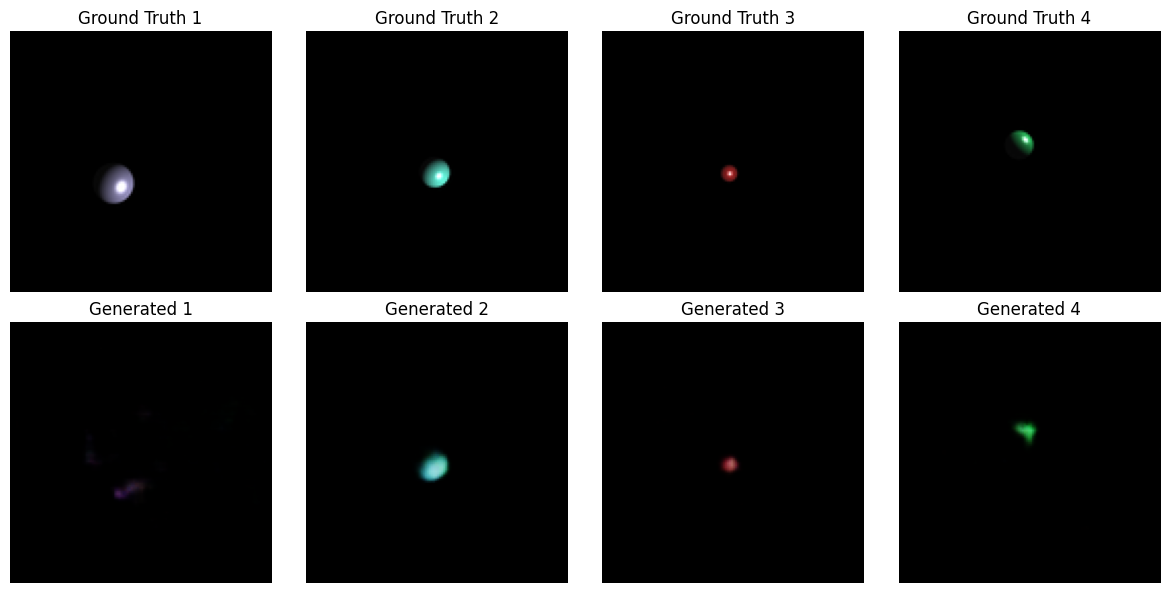

Epoch [251/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0146, LR: 0.000250
Epoch [252/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0144, LR: 0.000250
Saved best model at epoch 252 with FLIP 0.0144
Epoch [253/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0145, LR: 0.000250
Epoch [254/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0144, LR: 0.000250
Saved best model at epoch 254 with FLIP 0.0144
Epoch [255/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0144, LR: 0.000250
Saved best model at epoch 255 with FLIP 0.0144
Epoch [256/500], Train Loss: 0.0004, Val Loss: 0.0056, Val FLIP: 0.0144, LR: 0.000250
Epoch [257/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0142, LR: 0.000250
Saved best model at epoch 257 with FLIP 0.0142
Epoch [258/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0143, LR: 0.000250
Epoch [259/500], Train Loss: 0.0004, Val Loss: 0.0057, Val FLIP: 0.0144, LR: 0.000250
Epoch [260/500], Train Loss: 0.0004, V

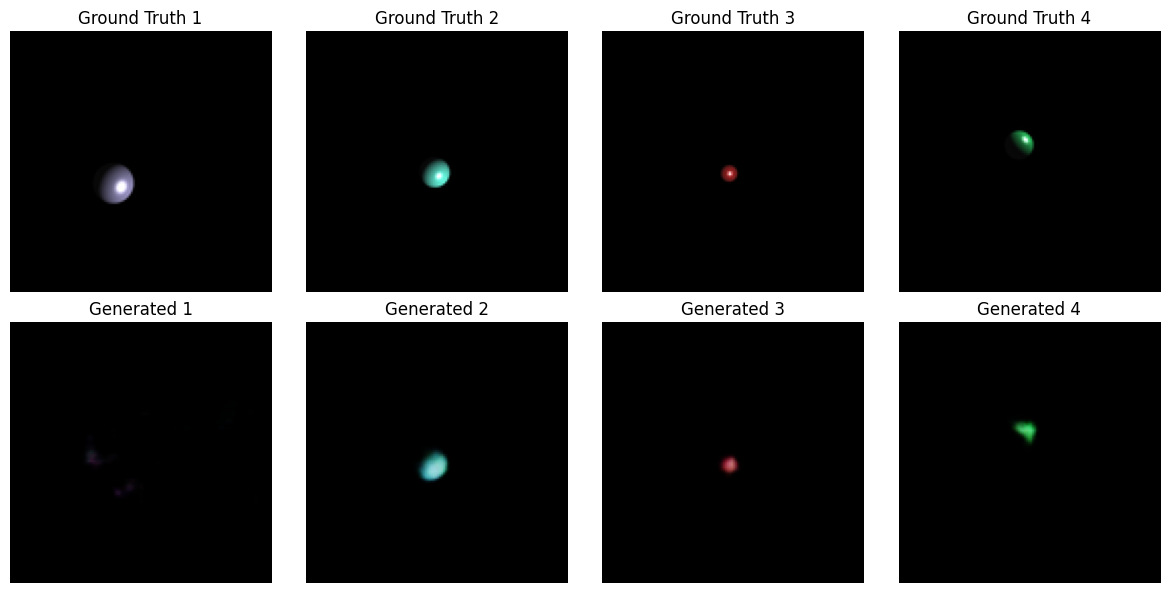

Epoch [261/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0141, LR: 0.000250
Saved best model at epoch 261 with FLIP 0.0141
Epoch [262/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0143, LR: 0.000250
Epoch [263/500], Train Loss: 0.0003, Val Loss: 0.0056, Val FLIP: 0.0143, LR: 0.000250
Epoch [264/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0142, LR: 0.000250
Epoch [265/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0142, LR: 0.000250
Epoch [266/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0142, LR: 0.000250
Epoch [267/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0141, LR: 0.000250
Saved best model at epoch 267 with FLIP 0.0141
Epoch [268/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0141, LR: 0.000250
Epoch [269/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0143, LR: 0.000250
Epoch [270/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0141, LR: 0.000250
Saved best model at epoch 270 with FLIP 0.0141

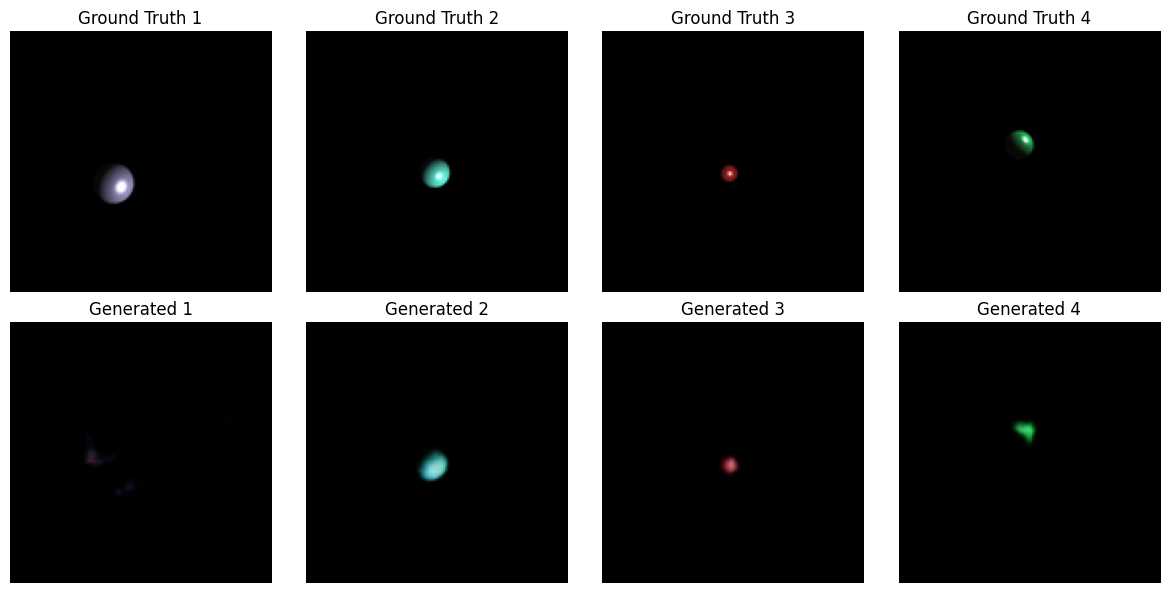

Epoch [271/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Saved best model at epoch 271 with FLIP 0.0137
Epoch [272/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [273/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [274/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0139, LR: 0.000250
Epoch [275/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [276/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0141, LR: 0.000250
Epoch [277/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0139, LR: 0.000250
Epoch [278/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [279/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0139, LR: 0.000250
Epoch [280/500], Train Loss: 0.0003, Val Loss: 0.0056, Val FLIP: 0.0139, LR: 0.000250


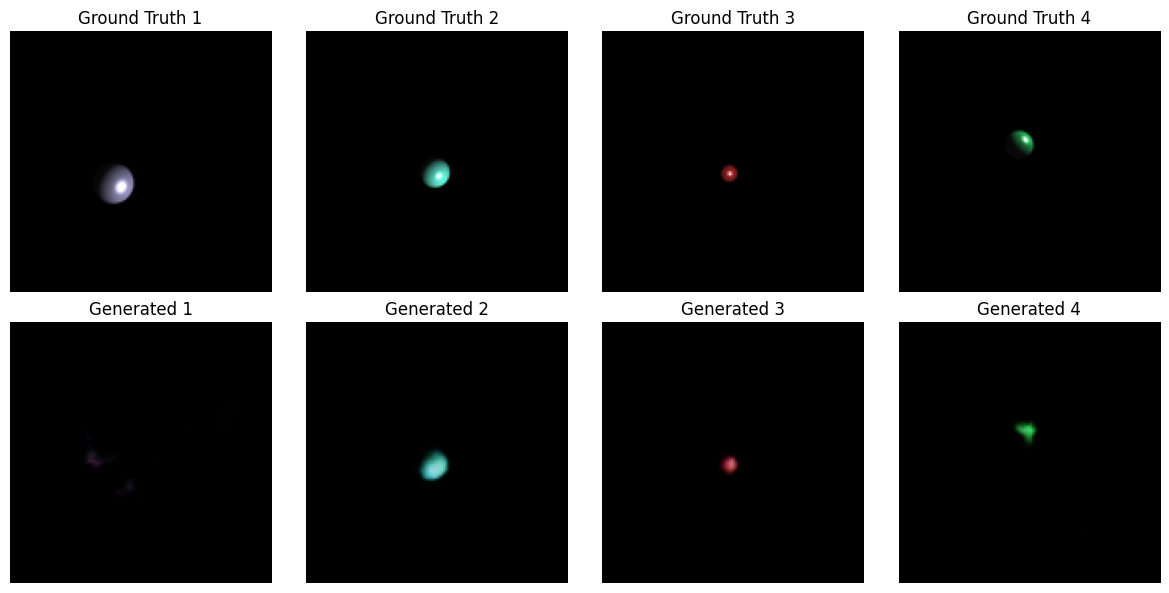

Epoch [281/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0139, LR: 0.000250
Epoch [282/500], Train Loss: 0.0003, Val Loss: 0.0056, Val FLIP: 0.0137, LR: 0.000250
Saved best model at epoch 282 with FLIP 0.0137
Epoch [283/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [284/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Saved best model at epoch 284 with FLIP 0.0137
Epoch [285/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0139, LR: 0.000250
Epoch [286/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0140, LR: 0.000250
Epoch [287/500], Train Loss: 0.0003, Val Loss: 0.0056, Val FLIP: 0.0138, LR: 0.000250
Epoch [288/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Epoch [289/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0138, LR: 0.000250
Epoch [290/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Saved best model at epoch 290 with FLIP 0.0137

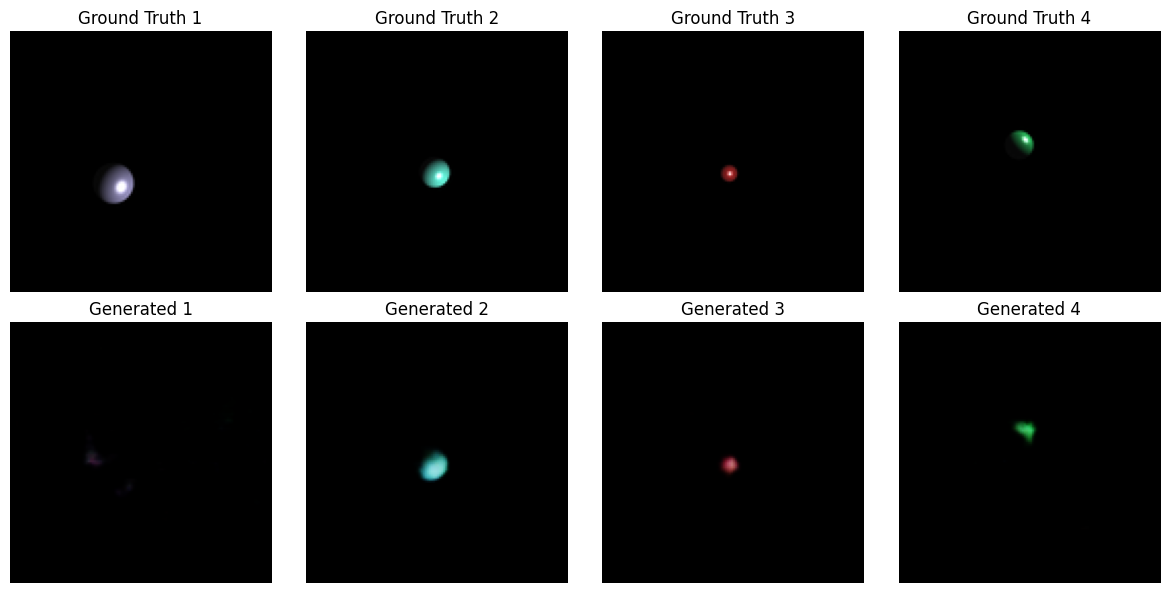

Epoch [291/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Epoch [292/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000250
Saved best model at epoch 292 with FLIP 0.0135
Epoch [293/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0138, LR: 0.000250
Epoch [294/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0136, LR: 0.000250
Epoch [295/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0136, LR: 0.000250
Epoch [296/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0137, LR: 0.000250
Epoch [297/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000250
Epoch [298/500], Train Loss: 0.0003, Val Loss: 0.0056, Val FLIP: 0.0132, LR: 0.000250
Saved best model at epoch 298 with FLIP 0.0132
Epoch [299/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000250
Epoch [300/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0136, LR: 0.000250


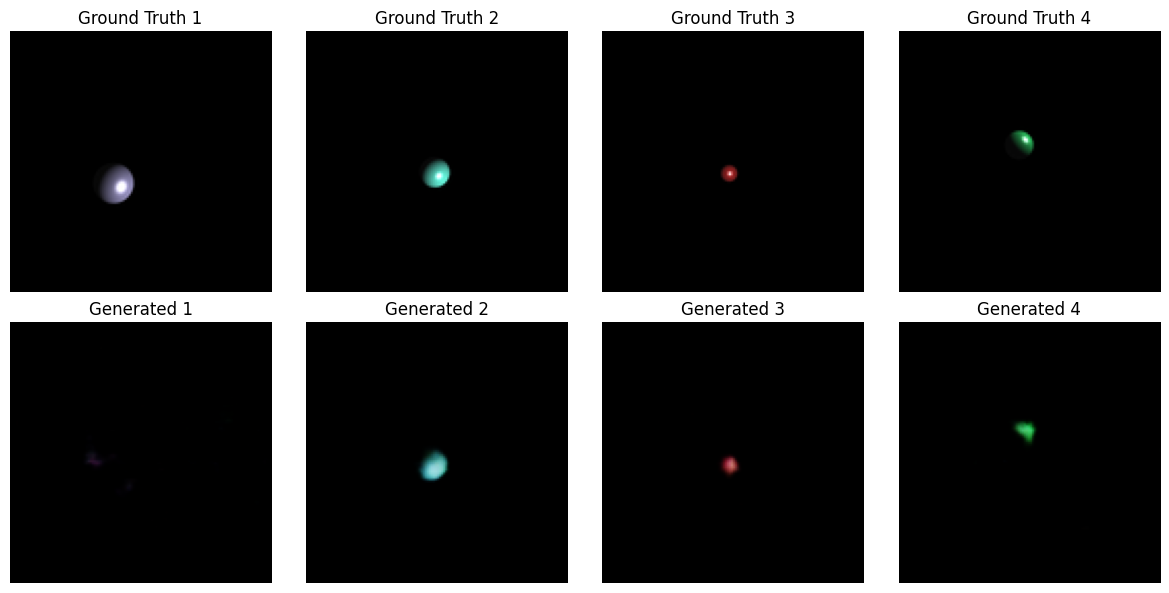

Epoch [301/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [302/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [303/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [304/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [305/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [306/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [307/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0136, LR: 0.000125
Epoch [308/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125
Epoch [309/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [310/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125


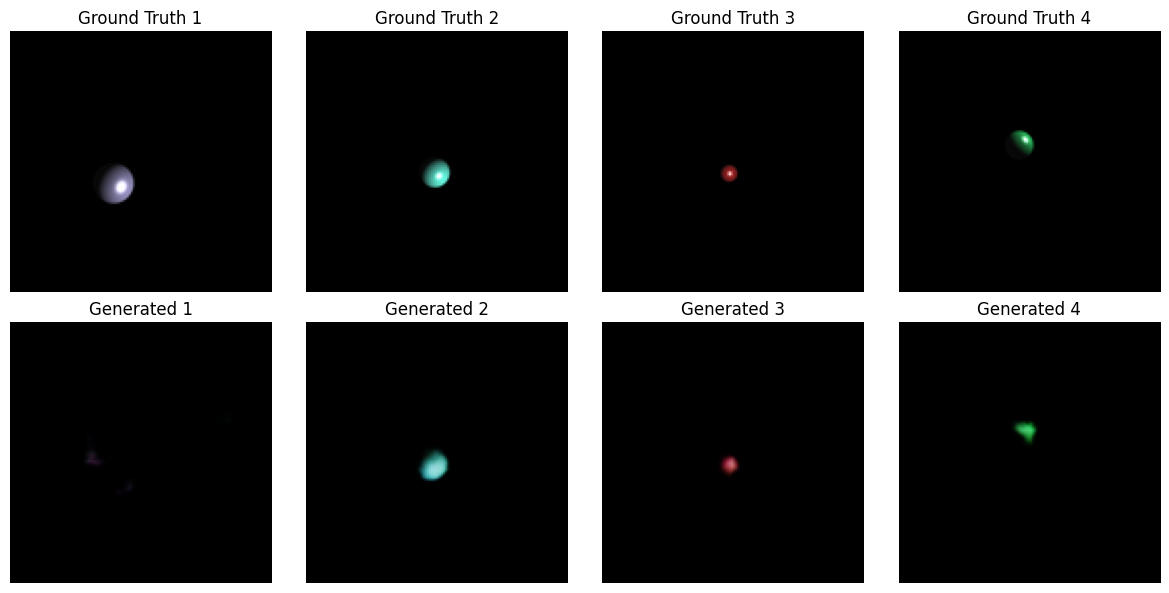

Epoch [311/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0135, LR: 0.000125
Epoch [312/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125
Epoch [313/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125
Epoch [314/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125
Epoch [315/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [316/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0134, LR: 0.000125
Epoch [317/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [318/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Epoch [319/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [320/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125


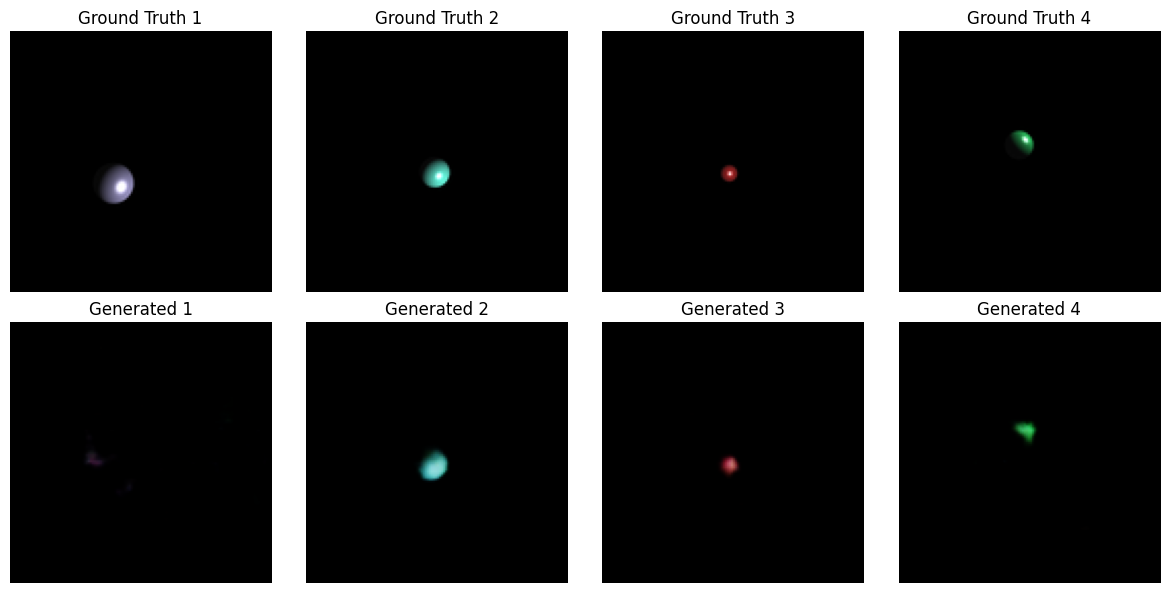

Epoch [321/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [322/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [323/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [324/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [325/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [326/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [327/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [328/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0133, LR: 0.000125
Epoch [329/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0132, LR: 0.000125
Epoch [330/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0133, LR: 0.000125


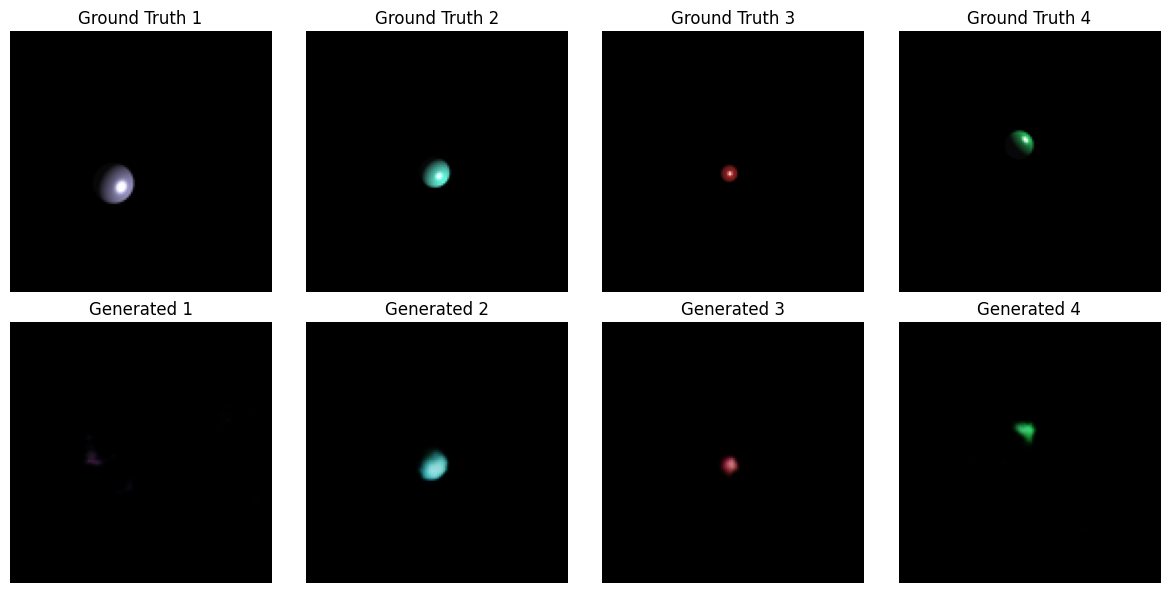

Epoch [331/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Saved best model at epoch 331 with FLIP 0.0132
Epoch [332/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [333/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0131, LR: 0.000125
Saved best model at epoch 333 with FLIP 0.0131
Epoch [334/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Epoch [335/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0132, LR: 0.000125
Epoch [336/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Epoch [337/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Epoch [338/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0133, LR: 0.000125
Epoch [339/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0132, LR: 0.000125
Epoch [340/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125


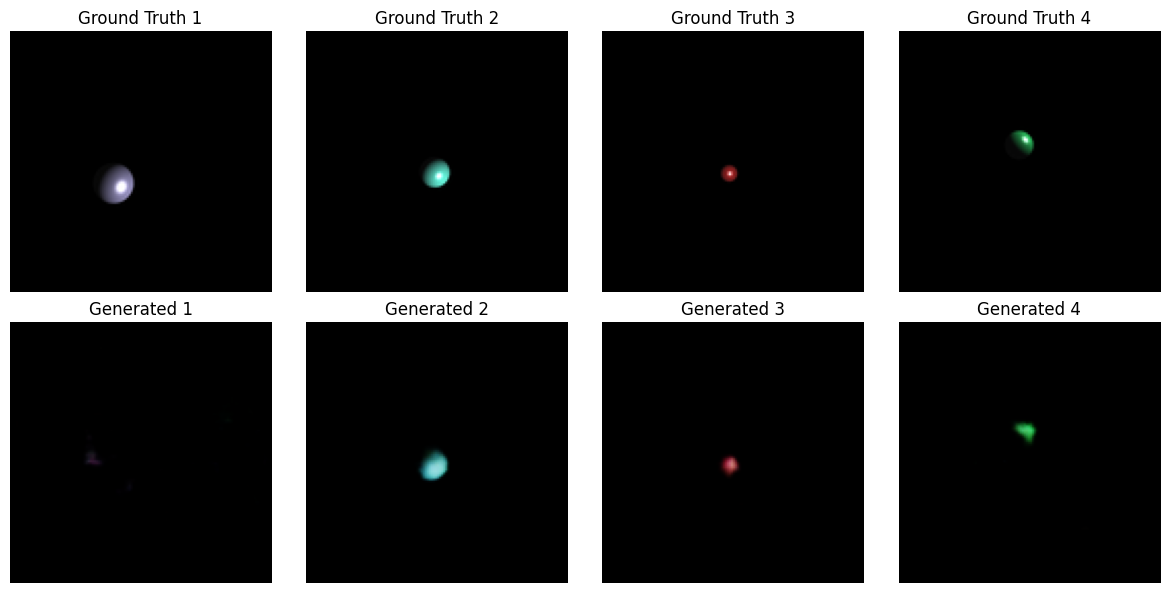

Epoch [341/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0132, LR: 0.000125
Epoch [342/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0133, LR: 0.000125
Epoch [343/500], Train Loss: 0.0003, Val Loss: 0.0058, Val FLIP: 0.0133, LR: 0.000125
Epoch [344/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0132, LR: 0.000125
Epoch [345/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Saved best model at epoch 345 with FLIP 0.0130
Epoch [346/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [347/500], Train Loss: 0.0003, Val Loss: 0.0057, Val FLIP: 0.0131, LR: 0.000125
Epoch [348/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [349/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0131, LR: 0.000125
Epoch [350/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125


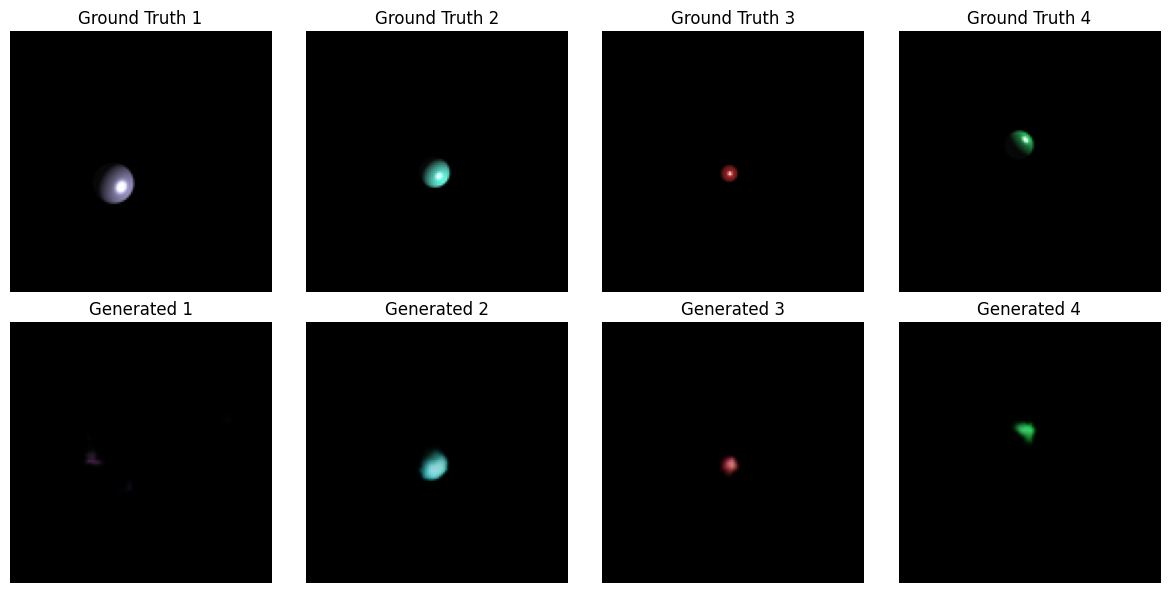

Epoch [351/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [352/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [353/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [354/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [355/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [356/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [357/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0131, LR: 0.000125
Epoch [358/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [359/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [360/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125


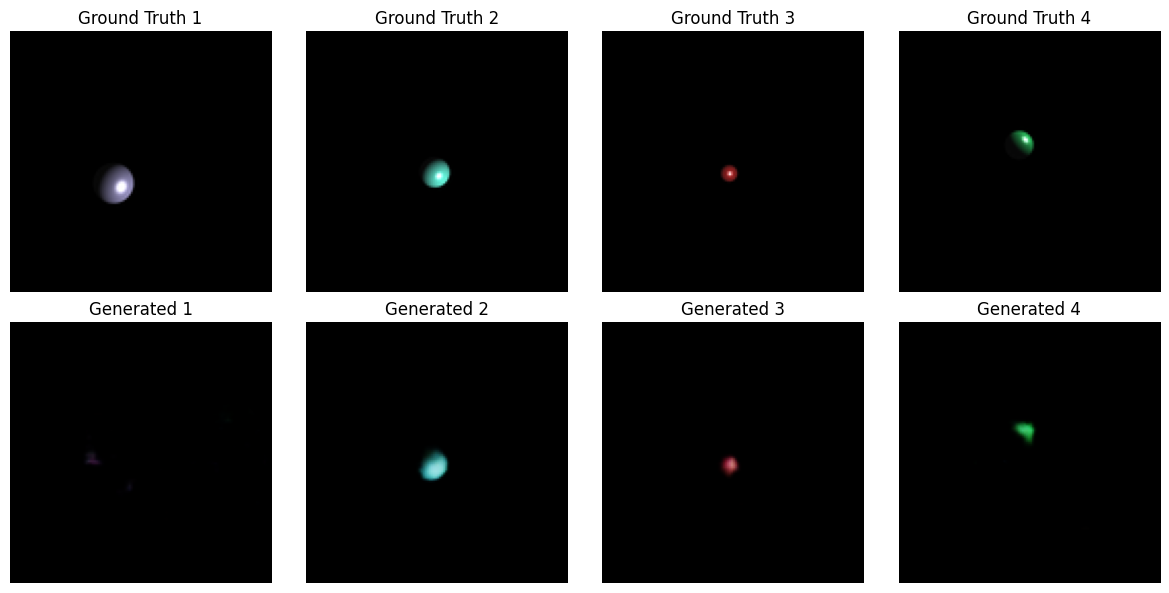

Epoch [361/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [362/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [363/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [364/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [365/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0131, LR: 0.000125
Epoch [366/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [367/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [368/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [369/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [370/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0129, LR: 0.000125
Saved best model at epoch 370 with FLIP 0.0129


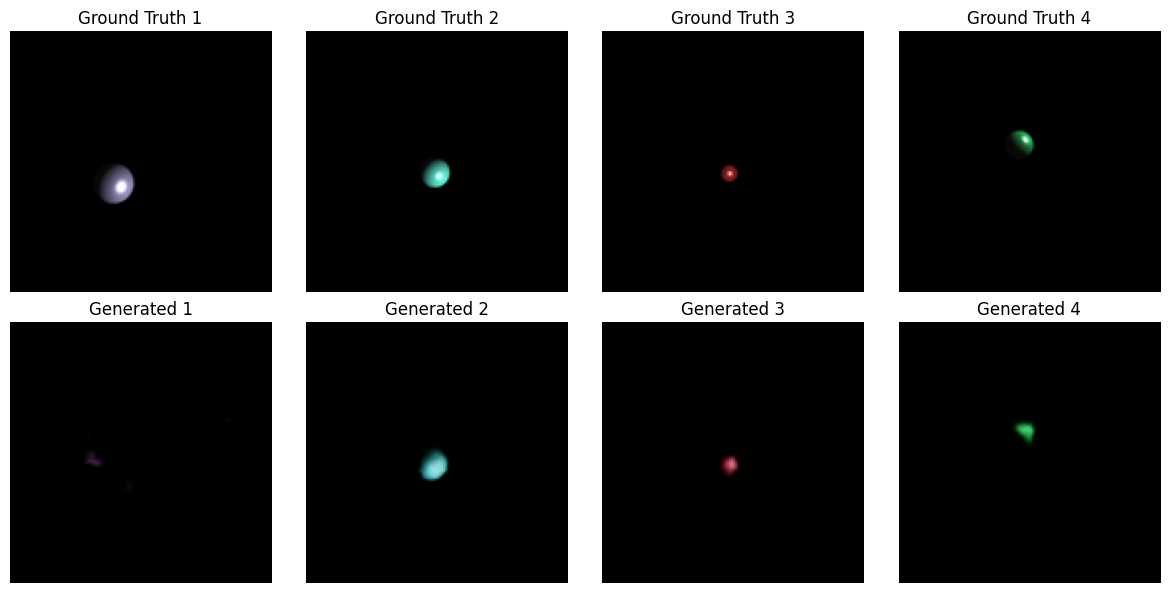

Epoch [371/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0130, LR: 0.000125
Epoch [372/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [373/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [374/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0129, LR: 0.000125
Epoch [375/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [376/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [377/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [378/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0129, LR: 0.000125
Epoch [379/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0129, LR: 0.000125
Epoch [380/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125


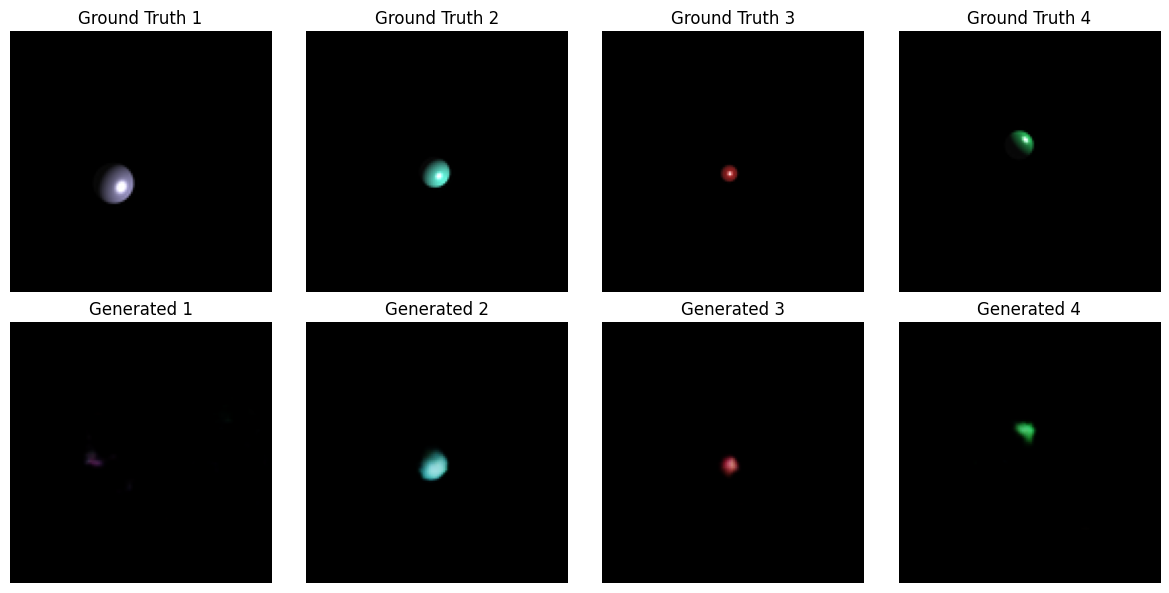

Epoch [381/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [382/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [383/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0130, LR: 0.000125
Epoch [384/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [385/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [386/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [387/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000125
Saved best model at epoch 387 with FLIP 0.0128
Epoch [388/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [389/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000125
Saved best model at epoch 389 with FLIP 0.0128
Epoch [390/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125


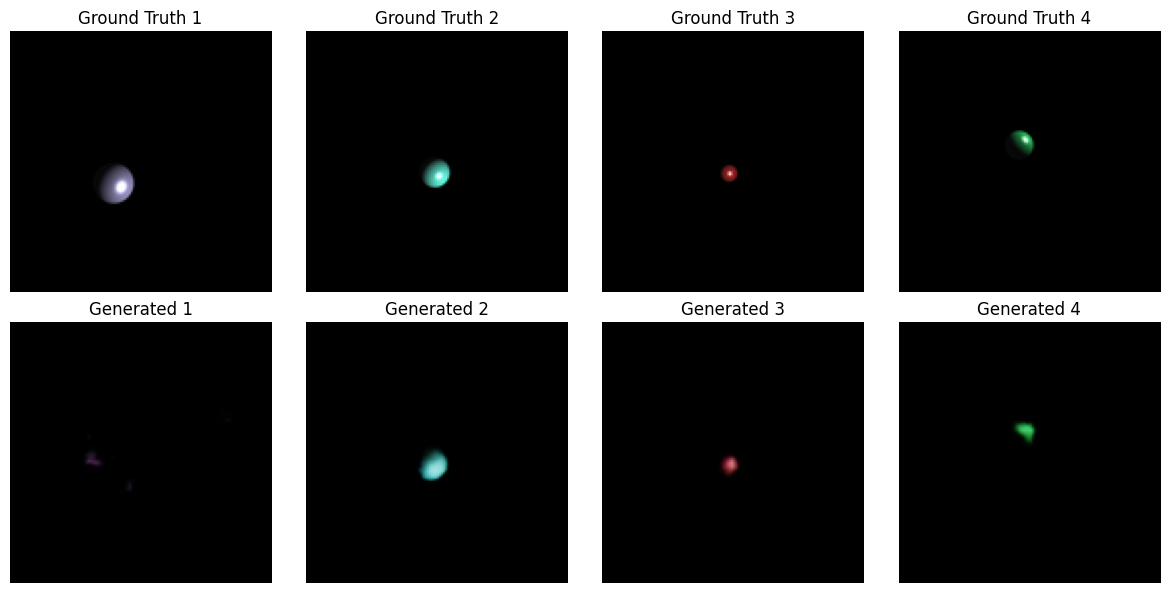

Epoch [391/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000125
Epoch [392/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [393/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [394/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [395/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0128, LR: 0.000125
Saved best model at epoch 395 with FLIP 0.0128
Epoch [396/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [397/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0128, LR: 0.000125
Epoch [398/500], Train Loss: 0.0002, Val Loss: 0.0057, Val FLIP: 0.0127, LR: 0.000125
Saved best model at epoch 398 with FLIP 0.0127
Epoch [399/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125
Epoch [400/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000125


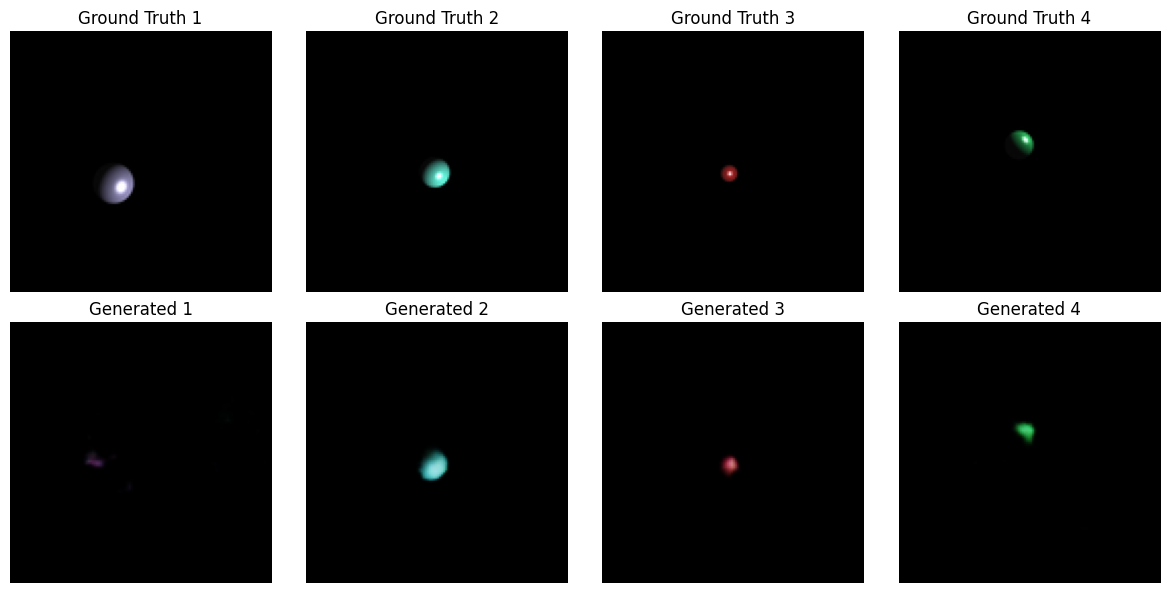

Epoch [401/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [402/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [403/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [404/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [405/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [406/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [407/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [408/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [409/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [410/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063


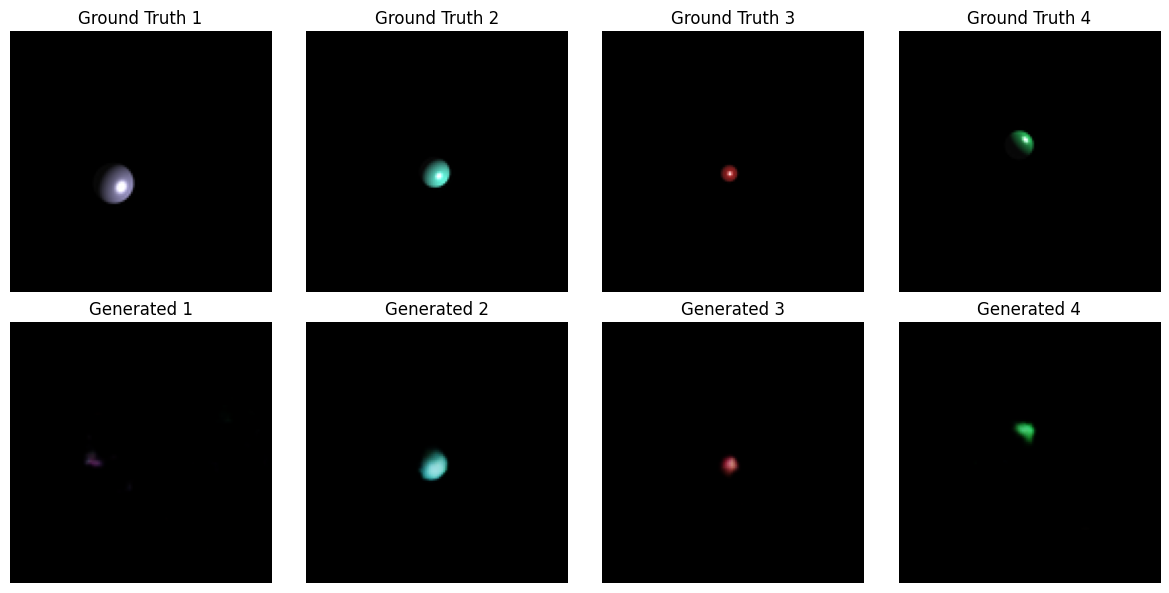

Epoch [411/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [412/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [413/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [414/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [415/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [416/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [417/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [418/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [419/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [420/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063


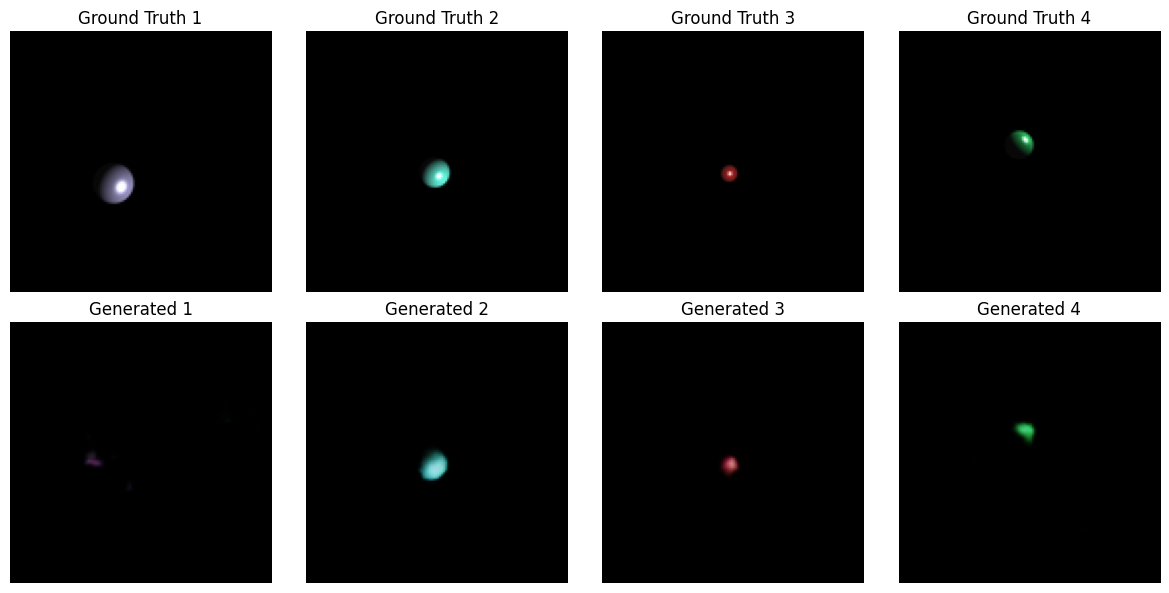

Epoch [421/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [422/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [423/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [424/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [425/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [426/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [427/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [428/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [429/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [430/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063


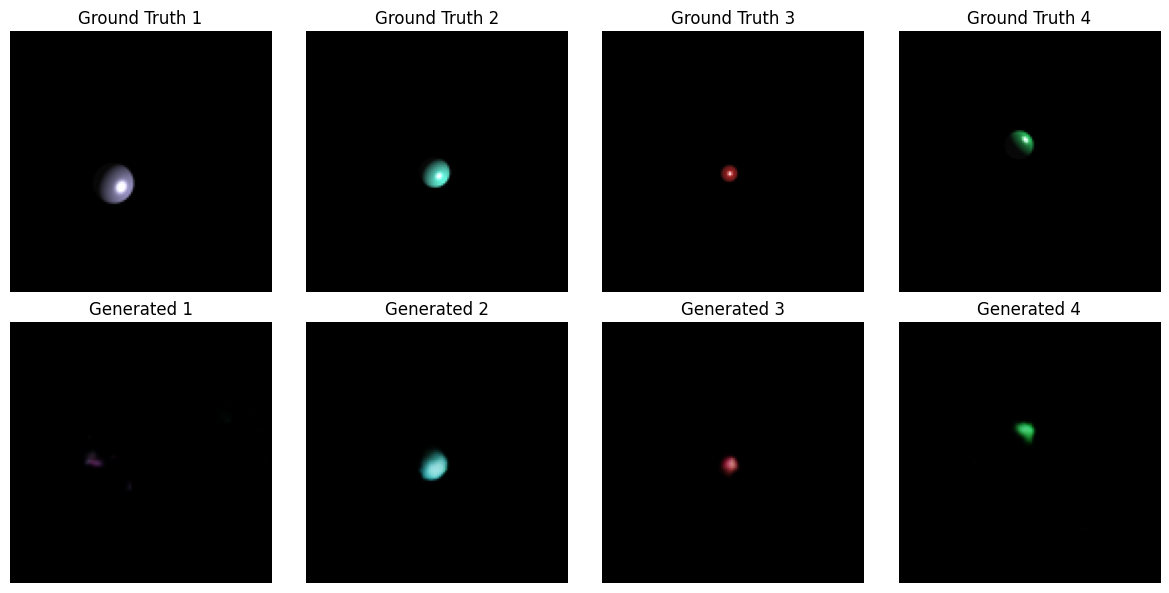

Epoch [431/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [432/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [433/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0129, LR: 0.000063
Epoch [434/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [435/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [436/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [437/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [438/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [439/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [440/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063


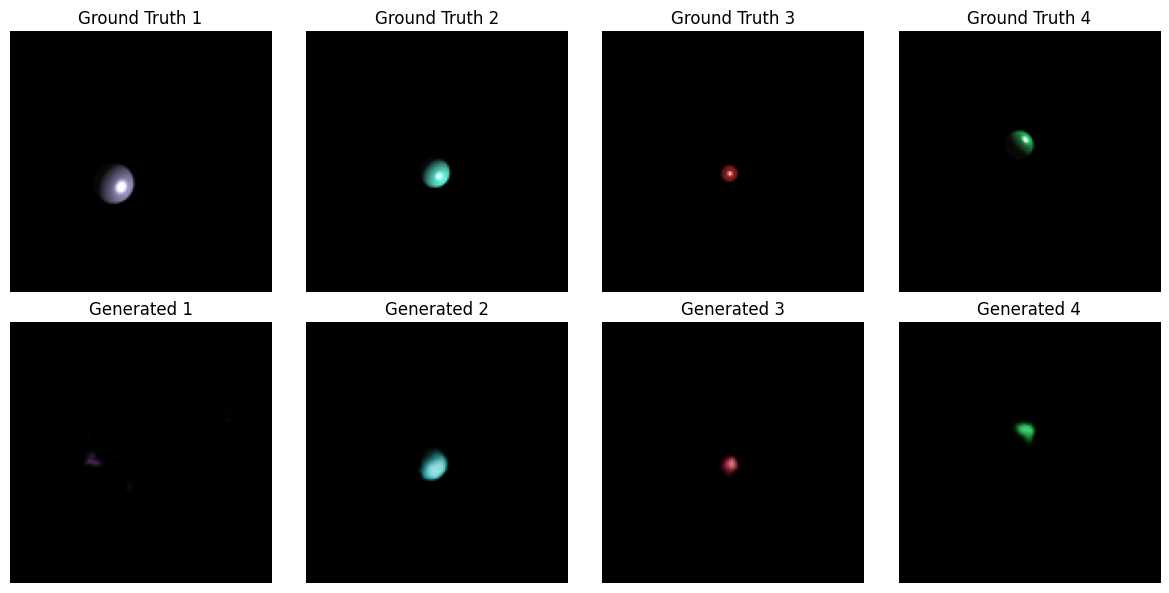

Epoch [441/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [442/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [443/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [444/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [445/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [446/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [447/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [448/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [449/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [450/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063


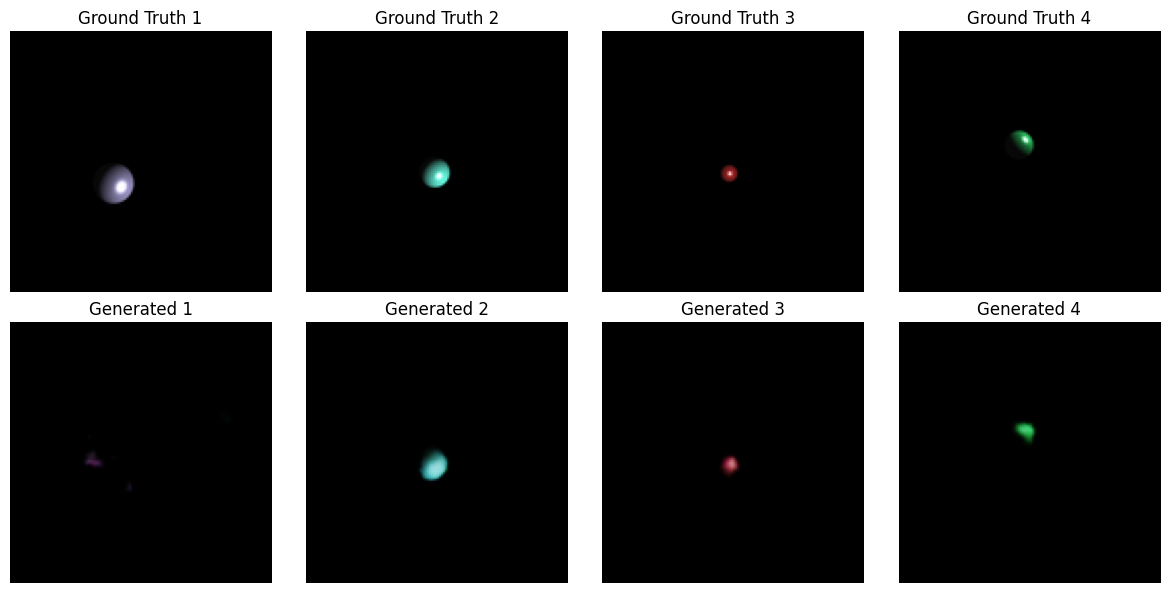

Epoch [451/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [452/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [453/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [454/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [455/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [456/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [457/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [458/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Saved best model at epoch 458 with FLIP 0.0127
Epoch [459/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [460/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063


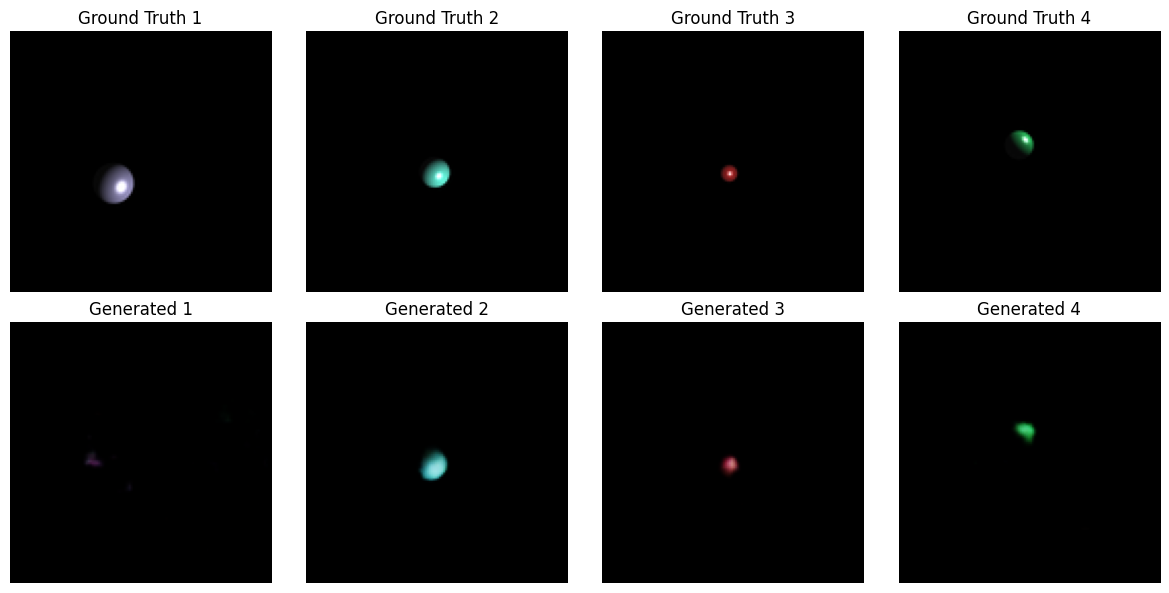

Epoch [461/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [462/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [463/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [464/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [465/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [466/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [467/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [468/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [469/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [470/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063


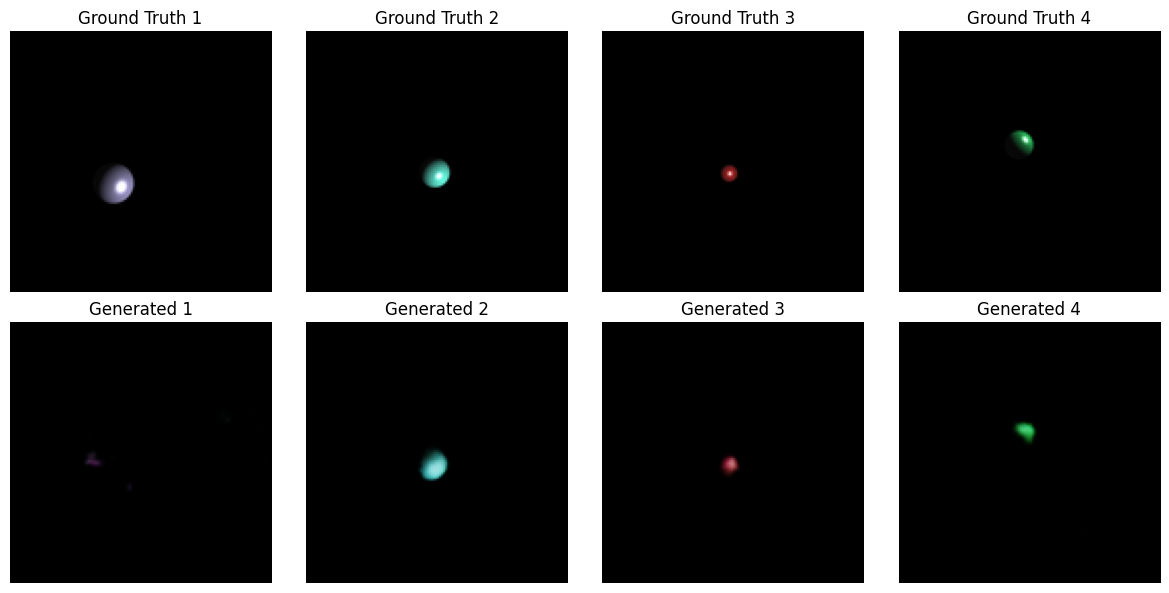

Epoch [471/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [472/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [473/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [474/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [475/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [476/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [477/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [478/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [479/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [480/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063


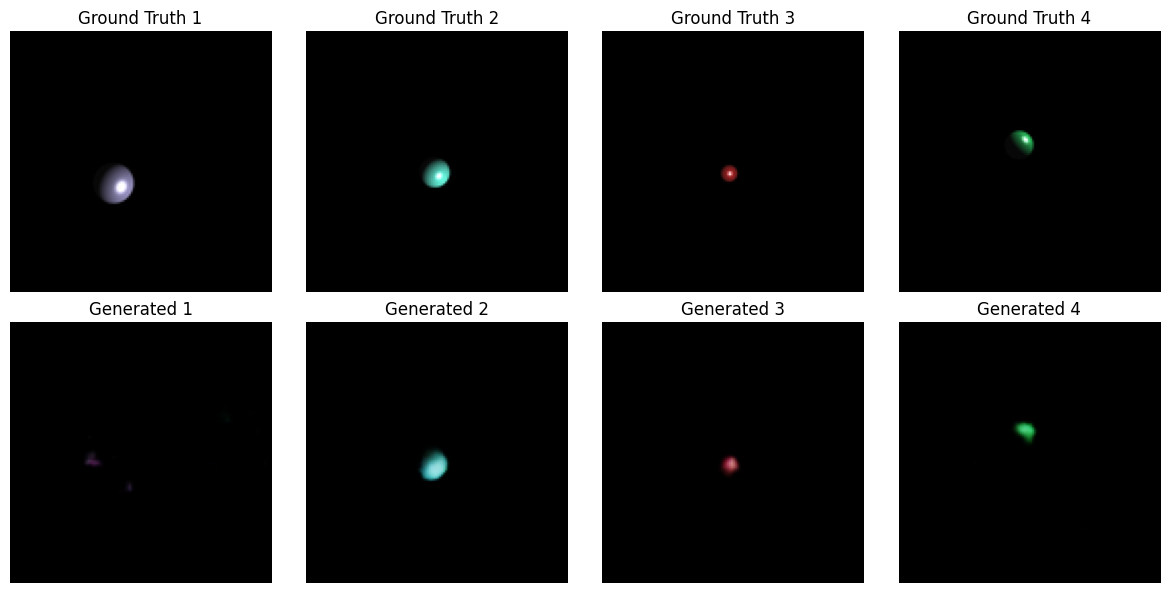

Epoch [481/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [482/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [483/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [484/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [485/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [486/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [487/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0126, LR: 0.000063
Saved best model at epoch 487 with FLIP 0.0126
Epoch [488/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [489/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [490/500], Train Loss: 0.0002, Val Loss: 0.0059, Val FLIP: 0.0127, LR: 0.000063


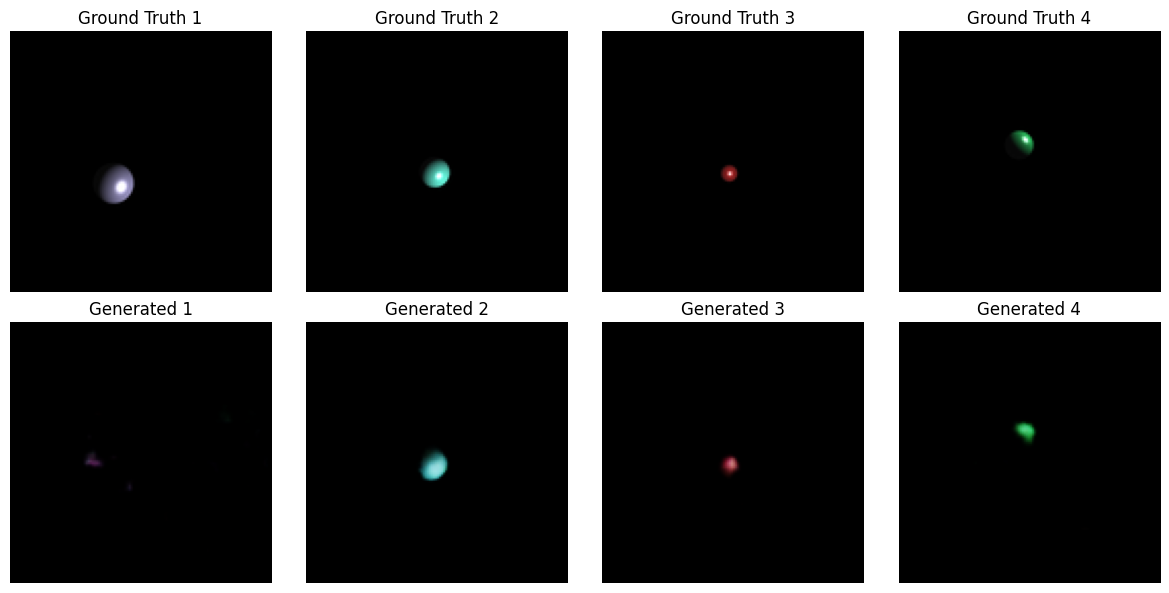

Epoch [491/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [492/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [493/500], Train Loss: 0.0002, Val Loss: 0.0059, Val FLIP: 0.0128, LR: 0.000063
Epoch [494/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [495/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [496/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0126, LR: 0.000063
Saved best model at epoch 496 with FLIP 0.0126
Epoch [497/500], Train Loss: 0.0002, Val Loss: 0.0059, Val FLIP: 0.0127, LR: 0.000063
Epoch [498/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0127, LR: 0.000063
Epoch [499/500], Train Loss: 0.0002, Val Loss: 0.0058, Val FLIP: 0.0128, LR: 0.000063
Epoch [500/500], Train Loss: 0.0002, Val Loss: 0.0059, Val FLIP: 0.0128, LR: 0.000063


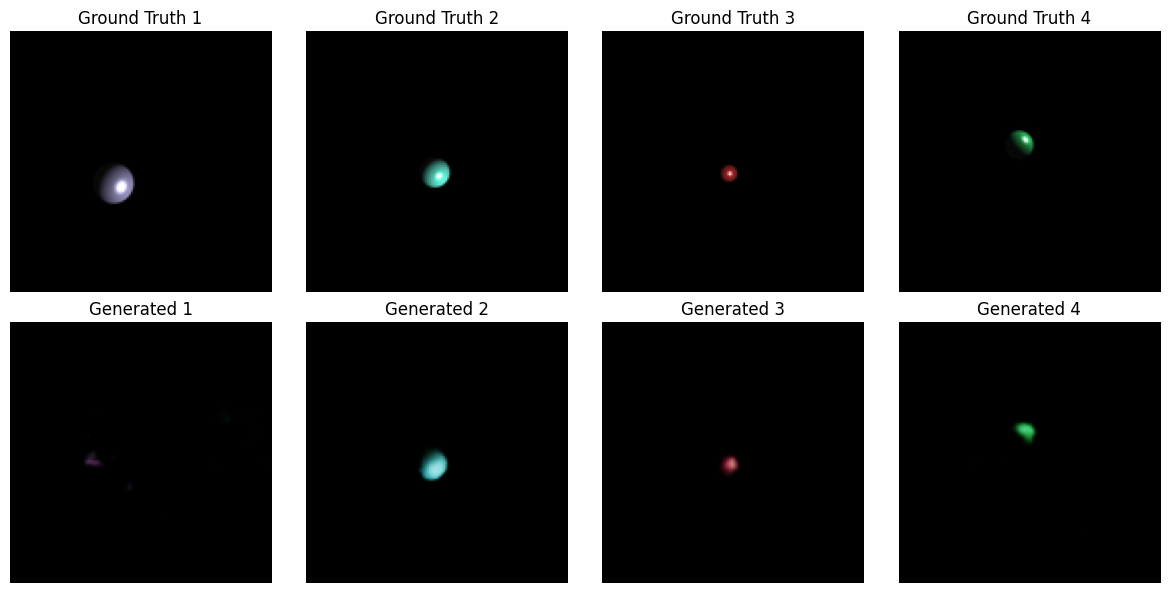

In [ ]:
train_loader, val_loader = get_data_loaders(
    PARAMS['csv_path'], PARAMS['image_dir'], PARAMS['batch_size'], PARAMS['train_split']
)
model = ImageGenerator(PARAMS['input_dim'], PARAMS['output_size'])
train_losses, val_losses, train_flips, val_flips = train_model(model, train_loader, val_loader, PARAMS)
